<a href="https://www.kaggle.com/code/catalystcooperative/01-pudl-data-access?scriptVersionId=198415133" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Purpose of this Notebook

Provide an introduction to working with the data integrated into Catalyst Cooperative's Public Utility Data Liberation (PUDL) database, from various public data sources. We will use PUDL to explore Companche 3's brief and checkered existence, in terms of its carbon emissions, electricity generation, costs, and reliability.

By the end of this notebook, you will be able to:
- use PUDL to access FERC, EIA, and EPA data about a specific power plant
- use that data, as well as the [PUDL data dictionary](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/pudl_db.html) to build a coherent narrative

# Comanche 3: A Snapshot of US Energy Transition

## Background
- In 2009 Xcel Energy Colorado (also known as Public Service Company of Colorado or PSCo) spent about 1.3 billion dollars building one of the last US coal plants in Pueblo, Colorado.
- The plant was bitterly contested from the beginning, with clean energy activists decrying the 60 years of future GHG emissions that the plant was to lock in, and declining economically accessible coal reserves in the Powder River Basin of Wyoming.
- After a decade of [high operating costs, ongoing maintenance issues](https://coloradosun.com/2021/03/03/comanche-3-cost-overruns-shutdown-electricity/), political pressure, and rapid renewable price declines, Xcel finally [agreed to shut the plant down 40 years early](https://coloradosun.com/2022/04/26/comanche-plant-xcel-coal/)


## Datasets we will use
- [FERC Form 1](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/ferc1.html) (the Annual Report of Major Electric Utilities) will provide non-fuel operating costs as well as ongoing capital expenses.
- [EIA Form 860](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/eia860.html) (the Annual Electric Generator Report) will provide detailed physical attributes of individual generators, as well as their ownership shares.
- [EIA Form 923](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/eia923.html) (the Power Plant Operations Report) will provide information about fuel consumption and costs, net electricity generation, and generator thermal efficiency.
- [EPA's Continuous Emissions Monitoring System](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/epacems.html) will provide hourly power plant emissions, fuel consumption, and power output.


## Attributes we will dig into

- cost increases & downtime (plant level)
- monthly net generation/fuel cost/heat rate/capacity factor (generator level)
- hourly power output, fuel consumption, heat rates, emissions intensity (unit level)



# Additional PUDL Project Resources
Links to more information on Catalyst Cooperative's Public Utility Data Liberation (PUDL) Project.

## PUDL Data Dictionaries:
* [Table and column level metadata for the PUDL database](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/pudl_db.html)
* [Table level metadata for 2020 and earlier raw FERC Form 1 DBF data](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/ferc1_db.html) (**Note:** the raw FERC Form 1 data is very difficult to work with. Check whether the table you want to work with has been cleaned up and imported into PUDL)
* All XBRL-derived FERC forms (2021 and later) have extensive metadata published alongside their databases in the nightly builds (see below). These take the form of a JSON version of their XBRL taxonomy, and a [datapackage descriptor](https://specs.frictionlessdata.io/data-package/) that annotates the XBRL-derived SQLite DB.

## Nightly Build Outputs:
We attempt to rebuild all of our data products each night, based on the code in [the development branch](https://github.com/catalyst-cooperative/pudl/tree/dev) of the [main PUDL repository on GitHub](https://github.com/catalyst-cooperative/pudl). 

The most recent successful build outputs can be downloaded directly from:
* [The PUDL Project in the AWS Open Data Registry](https://registry.opendata.aws/catalyst-cooperative-pudl/)
* [Direct AWS S3 download links](https://catalystcoop-pudl.readthedocs.io/en/latest/data_access.html#access-nightly-builds) on our data access page.
* The [PUDL Project Dataset](https://www.kaggle.com/datasets/catalystcooperative/pudl-project) on Kaggle updates automatically whenever the nightly builds succeed.

## Datasette: https://data.catalyst.coop
Successful nightly build outputs are also deployed using [Simon Willison](https://simonwillison.net/)'s excellent [Datasette](https://datasette.io/) tool. It provides a simple web interface for browsing and querying all of the SQLite databases we publish.

## GitHub Discussions
We use [GitHub Discussions](https://github.com/orgs/catalyst-cooperative/discussions) to answer questions about PUDL and provide user support. Let us know if you have issues or find bugs!

# Notebook Setup
Boilerplate setup. You don't have to think hard about this, but if you want to, the comments provide some useful context.

In [1]:
import sys
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

print(f"Python version: {sys.version}")
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlalchemy as sa

print(f"{np.__version__=}")
print(f"{pd.__version__=}")
print(f"{sa.__version__=}")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in sorted(filenames):
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
sns.set()
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16, 10)
matplotlib.rcParams["figure.dpi"] = 150
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 1000)

Python version: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]
np.__version__='1.26.4'
pd.__version__='2.2.2'
sa.__version__='2.0.30'
/kaggle/input/pudl-project/censusdp1tract.sqlite
/kaggle/input/pudl-project/ferc1_dbf.sqlite
/kaggle/input/pudl-project/ferc1_xbrl.sqlite
/kaggle/input/pudl-project/ferc1_xbrl_datapackage.json
/kaggle/input/pudl-project/ferc1_xbrl_taxonomy_metadata.json
/kaggle/input/pudl-project/ferc2_dbf.sqlite
/kaggle/input/pudl-project/ferc2_xbrl.sqlite
/kaggle/input/pudl-project/ferc2_xbrl_datapackage.json
/kaggle/input/pudl-project/ferc2_xbrl_taxonomy_metadata.json
/kaggle/input/pudl-project/ferc60_dbf.sqlite
/kaggle/input/pudl-project/ferc60_xbrl.sqlite
/kaggle/input/pudl-project/ferc60_xbrl_datapackage.json
/kaggle/input/pudl-project/ferc60_xbrl_taxonomy_metadata.json
/kaggle/input/pudl-project/ferc6_dbf.sqlite
/kaggle/input/pudl-project/ferc6_xbrl.sqlite
/kaggle/input/pudl-project/ferc6_xbrl_datapackage.json
/kaggle/input/pudl-pro

# Reading data from the PUDL SQLite Database
- Most of the PUDL Project data is distributed using SQLite databases.
 - Python, pandas, and many other libraries have built-in support for reading data from SQLite, and it is a file-based database that doesn't require running a database server, which is much simpler for local analysis and data distribution.
- Only one of these databases is meant for general public consumption: `pudl.sqlite`.
- The other SQLite databases pertain to various FERC forms and are unprocessed conversions of FERC's difficult to use original data formats (Visual FoxPro up to 2020, and XBRL starting in 2021). We will not look at these relatively raw inputs in this notebook.
- [SQLAlchemy](https://docs.sqlalchemy.org/en/20/) is Python's general purpose database access library, and is integrated directly with the [pandas](https://pandas.pydata.org/) data analysis library that you may already be familiar with.

## Create a connection engine for the PUDL Database

In [2]:
import pathlib
import sqlalchemy as sa

# Path to the directory that contains all the PUDL data on Kaggle:
pudl_path = pathlib.Path("/kaggle/input/pudl-project")

# Create a connection using SQLAlchemy, we'll pass this to pandas below to read data.
pudl_engine = sa.create_engine(f"sqlite:///{pudl_path}/pudl.sqlite")

## Read EIA plant data from the PUDL SQLite Database
- We'll read the entire [denormalized EIA plants table](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/pudl_db.html#denorm-plants-eia) -- "denormalized" just means that it has additional useful information merged in that might be duplicative, but is more convenient for interactive use.
- Power plants are industrial facilities operated by a single utility, but they can have multiple owners, and host multiple generation units.
- The `denorm_plants_eia` table contains only information that pertains to all of the equipment at the plant. like its location, or connections to the natural gas and electricity transmission systems.
- Most of these attributes are relatively stable, but they can change slowly over time, so each plant has one record for each `report_date`.
- There are also several ID columns in this table that will be useful for joining it with other data later.
- The table has more than 50 columns. You can look up short descriptions of what all these columns mean in the [PUDL Data Dictionary](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/pudl_db.html)

In [3]:
%%time
plants_eia = pd.read_sql("out_eia__yearly_plants", pudl_engine).convert_dtypes(convert_floating=False)

# Filter to plants with "comanche" in the name, so we can find the PUDL plant ID
plants_eia.loc[
    plants_eia.plant_name_eia.str.contains("comanche", case=False),
    [
        "plant_id_eia",
        "plant_id_pudl",
        "plant_name_eia",
        "utility_name_eia",
        "city",
        "state",
        "latitude",
        "longitude",
    ]
].drop_duplicates()

CPU times: user 7.05 s, sys: 961 ms, total: 8.01 s
Wall time: 8.46 s


plant_id_eia  plant_id_pudl  plant_name_eia  \
42082          59656           8375  Comanche Solar   
42088          59656           8375  Comanche Solar   
136965          8059            127        Comanche   
153240          6145           2514   Comanche Peak   
153254          6145           2514   Comanche Peak   
197808           470            126        Comanche   

                       utility_name_eia       city state   latitude  \
42082                    Novatus Energy     Pueblo    CO  38.205276   
42088                      Comanche LLC     Pueblo    CO  38.205276   
136965    Public Service Co of Oklahoma     Lawton    OK  34.543098   
153240  Luminant Generation Company LLC  Glen Rose    TX  32.298367   
153254             TXU Generation Co LP  Glen Rose    TX  32.298367   
197808    Public Service Co of Colorado     Pueblo    CO  38.208099   

         longitude  
42082  -104.566704  
42088  -104.566704  
136965  -98.324402  
153240  -97.785522  
153254  -97.785522  
197808 -104.574699

## Reading FERC plant data from the PUDL SQLite DB
* The Federal Energy Regulatory Commission (FERC) also reports data about power plants in their [Form 1 - Annual Report of Major Electric Utilities](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/ferc1.html).
* FERC Form 1 focuses primarily on electric utility finances, rather than operations.
* The [Large Steam Plants](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/pudl_db.html) table provides particularly detailed capital expenses and non-fuel O&M costs.
* Unfortunately, these detailed costs are often not attributed to individual generators.
* In the case of Comanche, the costs and other data for all 3 units are lumped together at the plant level, obscuring the impact of Comanche 3.

In [4]:
%%time
plants_ferc1 = pd.read_sql("out_ferc1__yearly_steam_plants_sched402", pudl_engine).convert_dtypes(convert_floating=False)
plants_ferc1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32975 entries, 0 to 32974
Data columns (total 55 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   report_year                             32975 non-null  Int64  
 1   utility_id_ferc1                        32975 non-null  Int64  
 2   utility_id_pudl                         32975 non-null  Int64  
 3   utility_name_ferc1                      32975 non-null  string 
 4   plant_id_pudl                           32975 non-null  Int64  
 5   plant_id_ferc1                          32975 non-null  Int64  
 6   plant_name_ferc1                        32975 non-null  string 
 7   asset_retirement_cost                   10042 non-null  float64
 8   avg_num_employees                       19457 non-null  Int64  
 9   capacity_factor                         30381 non-null  float64
 10  capacity_mw                             32489 non-null  fl

/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [5]:
comanche_ferc1 = (
    plants_ferc1.loc[
        plants_ferc1["plant_id_pudl"] == 126,
        [
            "report_year",
            "plant_id_ferc1",
            "plant_name_ferc1",
            "plant_id_pudl",
            "capacity_mw",
            "net_generation_mwh",
            "capacity_factor",
            "capex_annual_addition",  # Total new capital additions for the year. Does not account for retirements / depreciation.
            "capex_annual_per_mw",    # Annual additions divided by plant capacity.
            "capex_annual_per_mwh",   # Annual additions divided by net generation for the year.
            "opex_total_nonfuel",     # Total non-fuel operating expensees. (EIA provides better fuel costs)
            "opex_per_mwh",           # Total operating expenses (including fuel) per MWh of net generation.
            "opex_nonfuel_per_mwh",   # Total non-fuel operating expenses per MWh of net generation.
            "opex_fuel_per_mwh",      # Total fuel-based operating expenses per MWh of net generation.
        ]
    ]
    .assign(report_date=lambda x: pd.to_datetime(x.report_year.astype("string")))
)
comanche_ferc1

report_year  plant_id_ferc1 plant_name_ferc1  plant_id_pudl  \
16517         1994            2688         comanche            126   
16518         1995            2688         comanche            126   
16519         1996            2688         comanche            126   
16520         1997            2688         comanche            126   
16521         1998            2688         comanche            126   
16522         1999            2688         comanche            126   
16523         2000            2688         comanche            126   
16524         2001            2688         comanche            126   
16525         2002            2688         comanche            126   
16526         2003            2688         comanche            126   
16527         2004            2688         comanche            126   
16528         2005            2688         comanche            126   
16529         2006            2688         comanche            126   
16530         2007            2688         comanche            126   
16531         2008            2688         comanche            126   
16532         2009            2688         comanche            126   
16533         2010            2688         comanche            126   
16534         2011            2688         comanche            126   
16535         2012            2688         comanche            126   
16536         2013            2688         comanche            126   
16537         2014            2688         comanche            126   
16538         2015            2688         comanche            126   
16539         2016            2688         comanche            126   
16540         2017            2688         comanche            126   
16541         2018            2688         comanche            126   
16542         2019            2688         comanche            126   
16543         2021            2688         comanche            126   
16544         2022            2688         comanche            126   
16545         2023            2688         comanche            126   
16717         2020            4314         comanche            126   

       capacity_mw  net_generation_mwh  capacity_factor  \
16517   700.000000           3253066.0         0.530507   
16518   700.000000           4023033.0         0.656072   
16519   700.000000           4319083.0         0.704351   
16520   700.000000           4424635.0         0.721565   
16521   700.000000           4437115.0         0.723600   
16522   700.000000           4563838.0         0.744266   
16523   700.000000           4223848.0         0.688821   
16524   700.000000           4431900.0         0.722750   
16525   700.000000           4697172.0         0.766010   
16526   700.000000           4864064.0         0.793226   
16527   700.000000           4301827.0         0.701537   
16528   700.000000           4292543.0         0.700023   
16529   700.000000           4877932.0         0.795488   
16530   700.000000           4450973.0         0.725860   
16531   700.000000           4378101.0         0.713976   
16532   778.500000           4705019.0         0.689920   
16533  1284.000000           5959070.0         0.529797   
16534  1635.300049           6169782.0         0.430693   
16535  1635.300049           7421325.0         0.518060   
16536  1635.300049           7239127.0         0.505341   
16537  1635.300049           6859537.0         0.478843   
16538  1635.300049           7029257.0         0.490691   
16539  1635.300049           7182730.0         0.501404   
16540  1635.300049           7577019.0         0.528928   
16541  1635.300049           7860923.0         0.548747   
16542  1635.300049           6658643.0         0.464819   
16543  1635.300049           6466549.0         0.451410   
16544  1635.300049           4579218.5         0.319661   
16545  1252.800049           4818090.0         0.439025   
16717  1635.300049           4116609.0         0.287368   

      

## Cost Increases and Downtime
- Some of the data available from FERC overlaps with the EIA and EPA data (see below). This lets us sanity check the various data sources against each other.
- Both FERC and EIA collect fuel cost and generation data, albeit at different resolutions. FERC Form 1 is reported annually, and typically not at the most granular level of individual generators.
- However, FERC is unique in reporting detailed categories of non-fuel O&M costs and plant capital additions, which are required to build a bottom-up picture of plant production costs.
- In the plots below we look at Comanche's overall plant capacity factor, fuel & non-fuel O&M costs, and the history of capital additions.

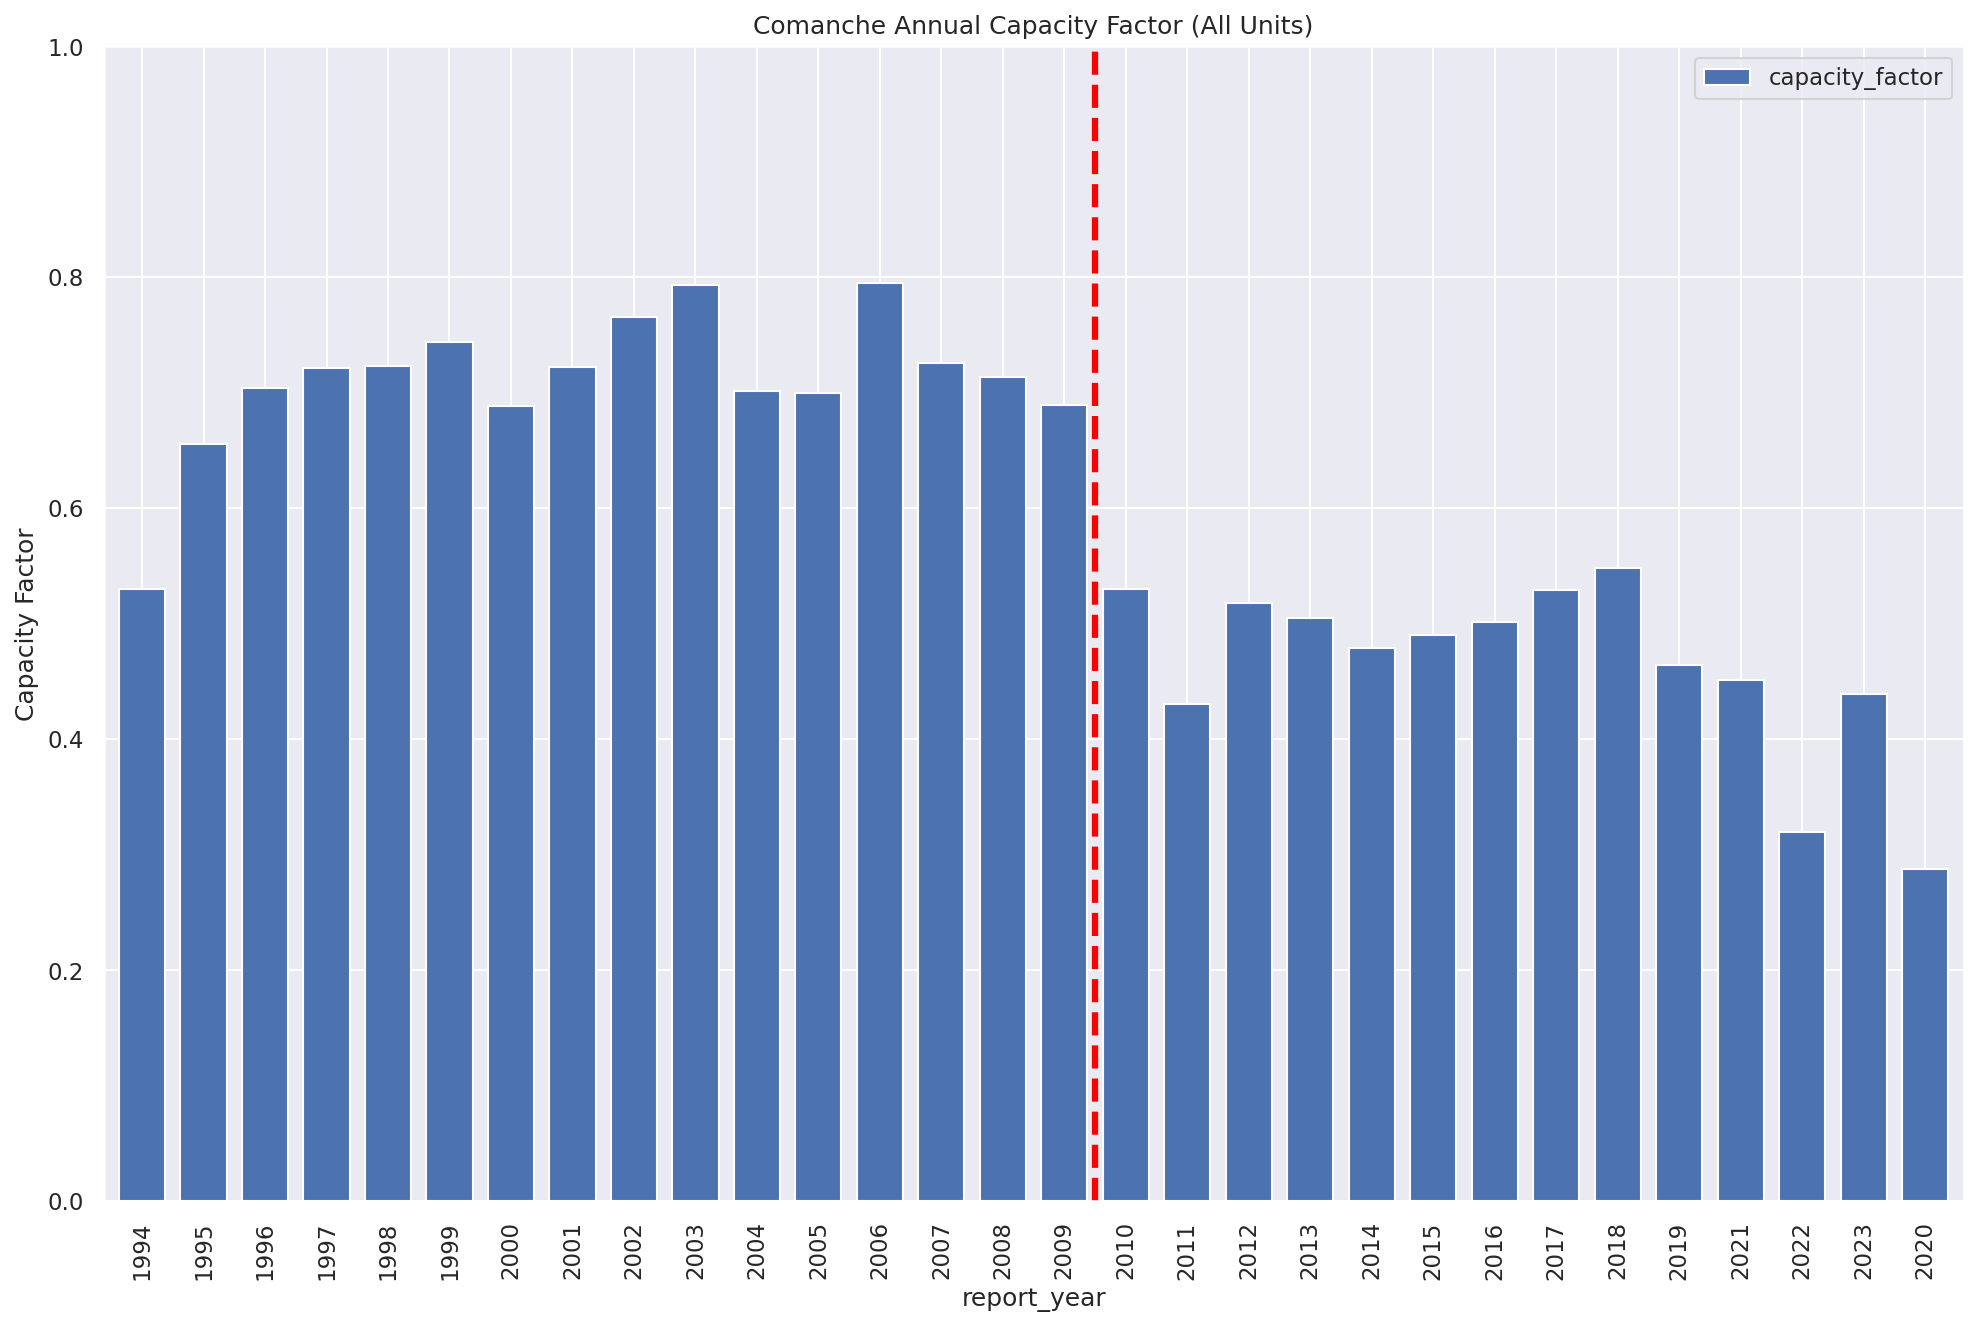

In [6]:
axes = comanche_ferc1.set_index("report_year")[[
    "capacity_factor",
]].plot(
    kind="bar",
    width=0.75,
)
axes.axvline(x=15.5, color="red", linestyle="--", lw=3)
axes.set_ylabel("Capacity Factor")
axes.set_title("Comanche Annual Capacity Factor (All Units)")
axes.set_ylim(0, 1);

- The red dashed line indicates when Unit 3 came online.
- Capacity Factor is the ratio of its actual generation to maximum possible generation if it ran at 100% capacity continuously.
- Overall plant capacity factor dropped sharply with the addition of the large new unit, from a historical level of ~70% to 50% even lower in recent years.

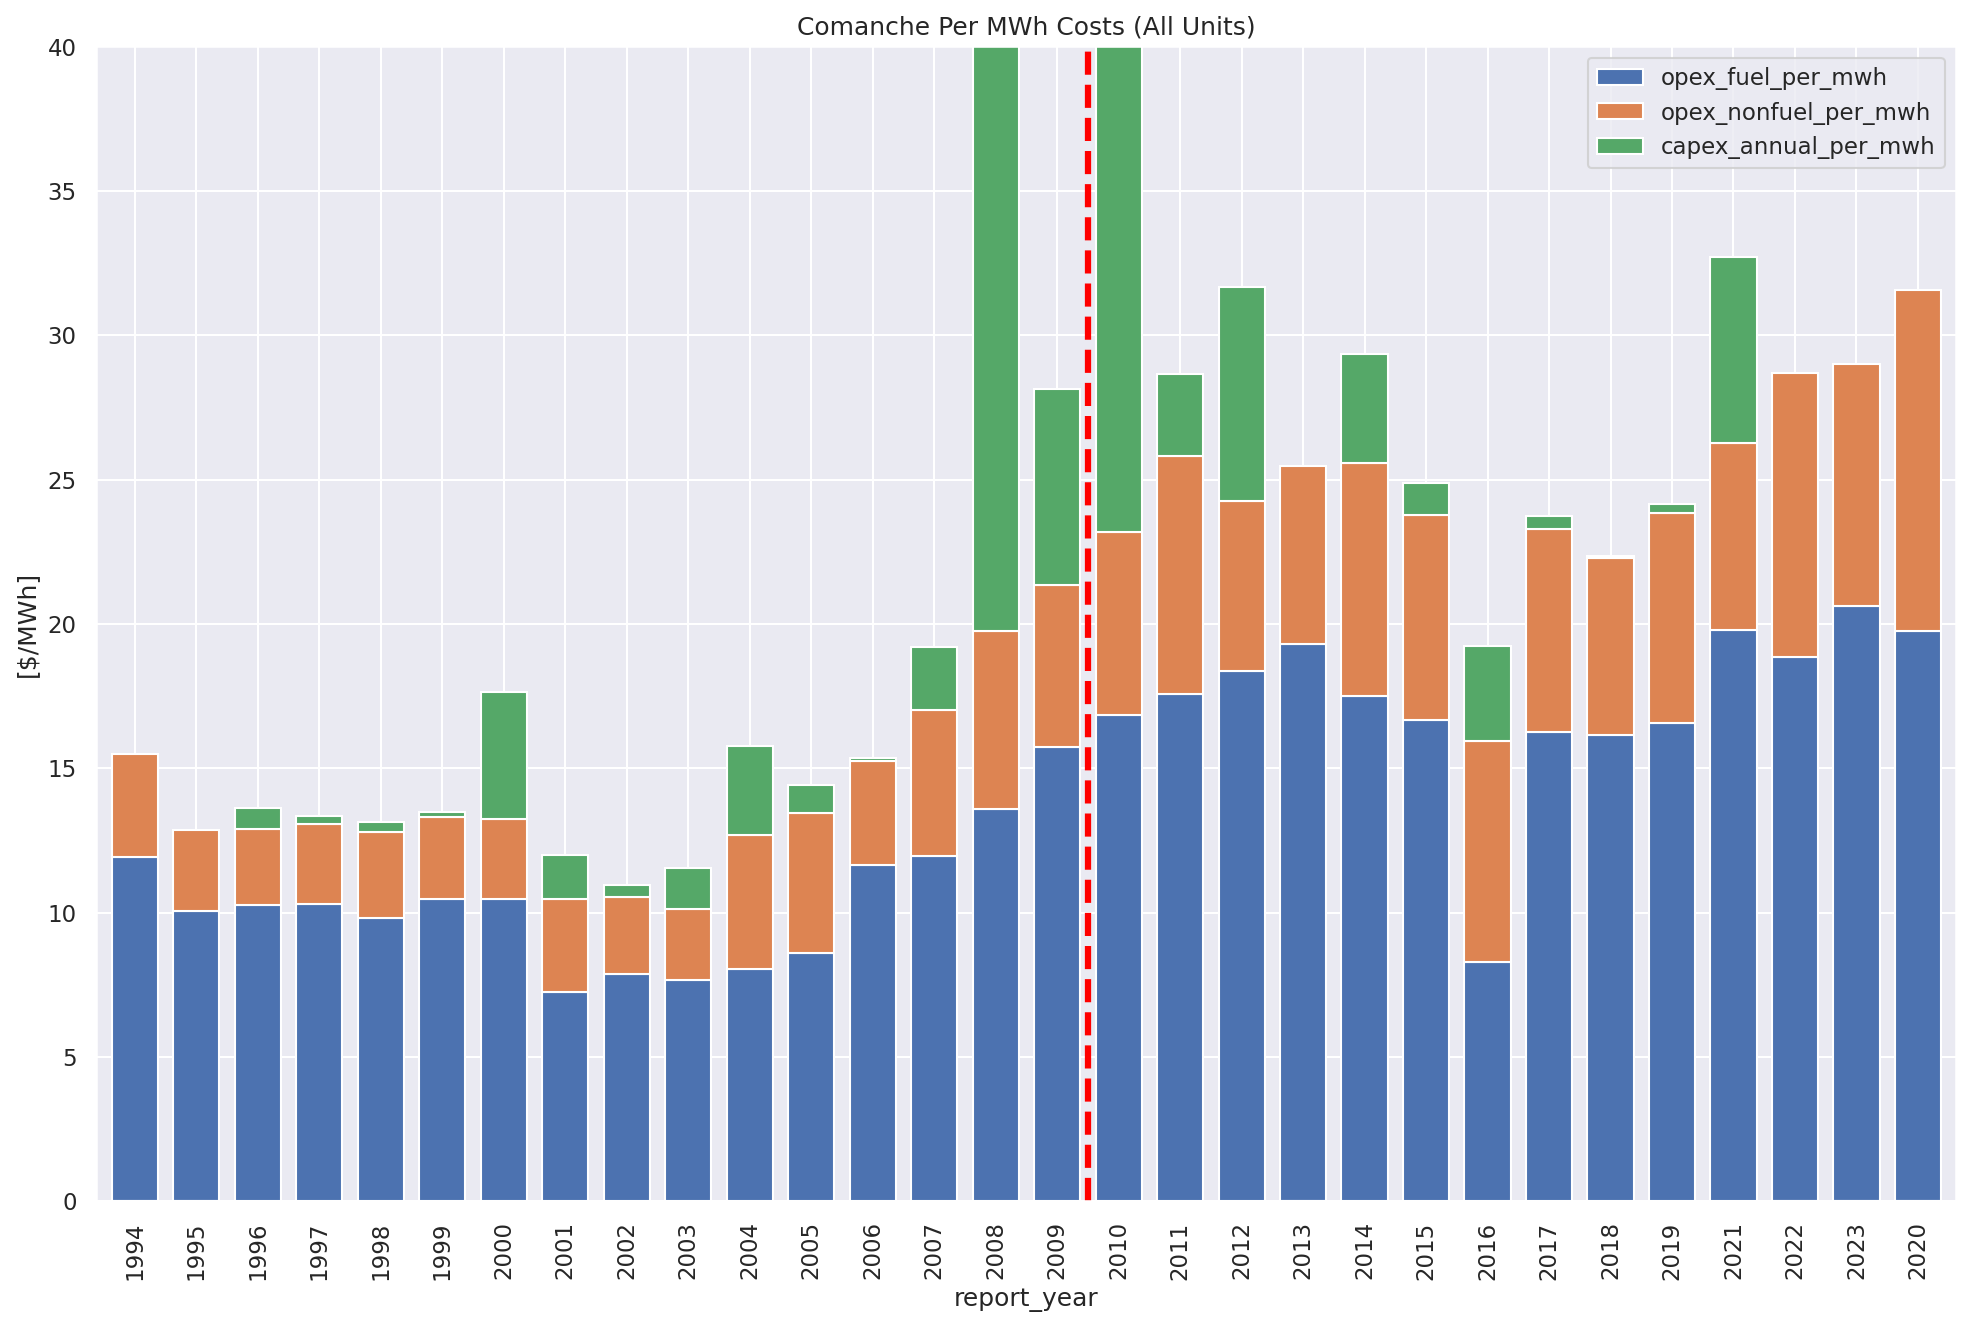

In [7]:
axes = comanche_ferc1.set_index("report_year")[[
    "opex_fuel_per_mwh",
    "opex_nonfuel_per_mwh",
    "capex_annual_per_mwh",
]].plot(
    kind="bar",
    stacked=True,
    width=0.75,
)
axes.axvline(x=15.5, color="red", linestyle="--", lw=3)
axes.set_ylabel("[$/MWh]")
axes.set_title("Comanche Per MWh Costs (All Units)")
axes.set_ylim(0, 40);

- At the same time, both fuel and non-fuel O&M costs per MWh increased significantly.
- Fuel prices are largely out of the utility's control and are a pure variable cost.
- The fuel costs in 2016 are anomalously low. Is this real, or a reporting error? EIA provides much more detailed fuel cost reporting (see below).
- Non-fuel O&M costs are a mix of fixed and variable costs. When fixed costs are spread out over a smaller number of MWh, the cost per MWh goes up.
- The capital additions plotted above really fall into 2 separate categories.
- There's a continuous background flow of money into the plant that's required to keep everything running -- some of which is categorized as O&M, and some of which gets categorized as capital investment and potentially added to the rate-base on which the utility earns a return.
- Prior to 2008 we can see an ongoing capital investment rate of sometehing like one USD per MWh of generation.
- In 2008 and 2010, capital additions are dramatically larger.
- In 2008 this was due to emissions controls that were added to the older Units 1 & 2.
- Then in 2010 the spike results from the more than 1 billion dollars of investmnet in Comanche 3 finally hitting the books.
- These large infrequent capital additions are meant to be paid off over multiple decades, and so aren't easily compared to the fuel and non-fuel O&M costs.
- However, the ongoing background trickle of capital additions is more like an ongoing maintenance cost, and are relatively comparable to the other O&M costs shown.


# Pre-calculated EIA Generator Statistics
* We have pre-calculated a number of useful generator statistics based on the EIA 860 and 923 data in the [MCOE Generators Tables](https://catalystcoop-pudl.readthedocs.io/en/latest/data_dictionaries/pudl_db.html#mcoe-generators-monthly)
* At first glance you might think these would be easy to calculate, but because of the different reporting requirements that apply to different sizes and types of power plants, that's unfortunately not true.
* These statistics are available both on a monthly and yearly basis.

In [8]:
%%time
comanche_mcoe = (
    pd.read_sql("SELECT * FROM out_eia__monthly_generators WHERE plant_id_eia=470", pudl_engine)
    .convert_dtypes(convert_floating=False)
    .sort_values(["report_date", "plant_id_eia", "generator_id"])
)
display(comanche_mcoe.info())
display(comanche_mcoe.sample(10))

<class 'pandas.core.frame.DataFrame'>
Index: 728 entries, 553 to 727
Columns: 110 entries, plant_id_eia to zip_code
dtypes: Int64(29), float64(15), object(37), string(29)
memory usage: 651.9+ KB


/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


None

plant_id_eia generator_id report_date  unit_id_pudl  plant_id_pudl  \
442           470            3  2014-10-01             3            126   
708           470            2  2006-11-01          <NA>            126   
175           470            1  2022-08-01             1            126   
660           470            2  2002-11-01          <NA>            126   
719           470            2  2007-10-01          <NA>            126   
88            470            1  2015-05-01             1            126   
133           470            1  2019-02-01             1            126   
447           470            3  2015-03-01             3            126   
520           470            3  2021-04-01             3            126   
524           470            3  2021-08-01             3            126   

    plant_name_eia  utility_id_eia  utility_id_pudl  \
442       Comanche           15466              272   
708       Comanche           15466              272   
175       Comanche           15466              272   
660       Comanche           15466              272   
719       Comanche           15466              272   
88        Comanche           15466              272   
133       Comanche           15466              272   
447       Comanche           15466              272   
520       Comanche           15466              272   
524       Comanche           15466              272   

                  utility_name_eia   technology_description  \
442  Public Service Co of Colorado  Conventional Steam Coal   
708  Public Service Co of Colorado  Conventional Steam Coal   
175  Public Service Co of Colorado  Conventional Steam Coal   
660  Public Service Co of Colorado  Conventional Steam Coal   
719  Public Service Co of Colorado  Conventional Steam Coal   
88   Public Service Co of Colorado  Conventional Steam Coal   
133  Public Service Co of Colorado  Conventional Steam Coal   
447  Public Service Co of Colorado  Conventional Steam Coal   
520  Public Service Co of Colorado  Conventional Steam Coal   
524  Public Service Co of Colorado  Conventional Steam Coal   

    energy_source_code_1 prime_mover_code generator_operating_date  \
442                  SUB               ST               2010-07-01   
708                  SUB               ST               1975-06-01   
175                  SUB               ST               1973-06-01   
660                  BIT               ST               1975-06-01   
719                  SUB               ST               1975-06-01   
88                   SUB               ST               1973-06-01   
133                  SUB               ST               1973-06-01   
447                  SUB               ST               2010-07-01   
520                  SUB               ST               2010-07-01   
524                  SUB               ST               2010-07-01   

    generator_retirement_date operational_status  capacity_mw  \
442                      <NA>           existing   856.799988   
708                      <NA>           existing   396.000000   
175                2022-12-01            retired   382.500000   
660                      <NA>           existing   350.000000   
719                      <NA>           existing   396.000000   
88                       <NA>           existing   382.500000   
133                      <NA>           existing   382.500000   
447                      <NA>           existing   856.799988   
520                      <NA>           existing   856.799988   
524                      <NA>           existing   856.799988   

    fuel_type_code_pudl planned_generator_retirement_date  capacity_factor  \
442                coal                              <NA>         0.014974   
708                coal                              <NA>         0.800591   
175                coal                              <NA>         0.460335   
660                coal                              <NA>         0.773714   
71

CPU times: user 1.29 s, sys: 2.02 s, total: 3.3 s
Wall time: 26.5 s


## Monthly Net Generation

Many generators report generator-level data. However, where generation is reported at the plant prime mover and fuel level, we allocate net generation to generators that share the same prime mover and fuels.

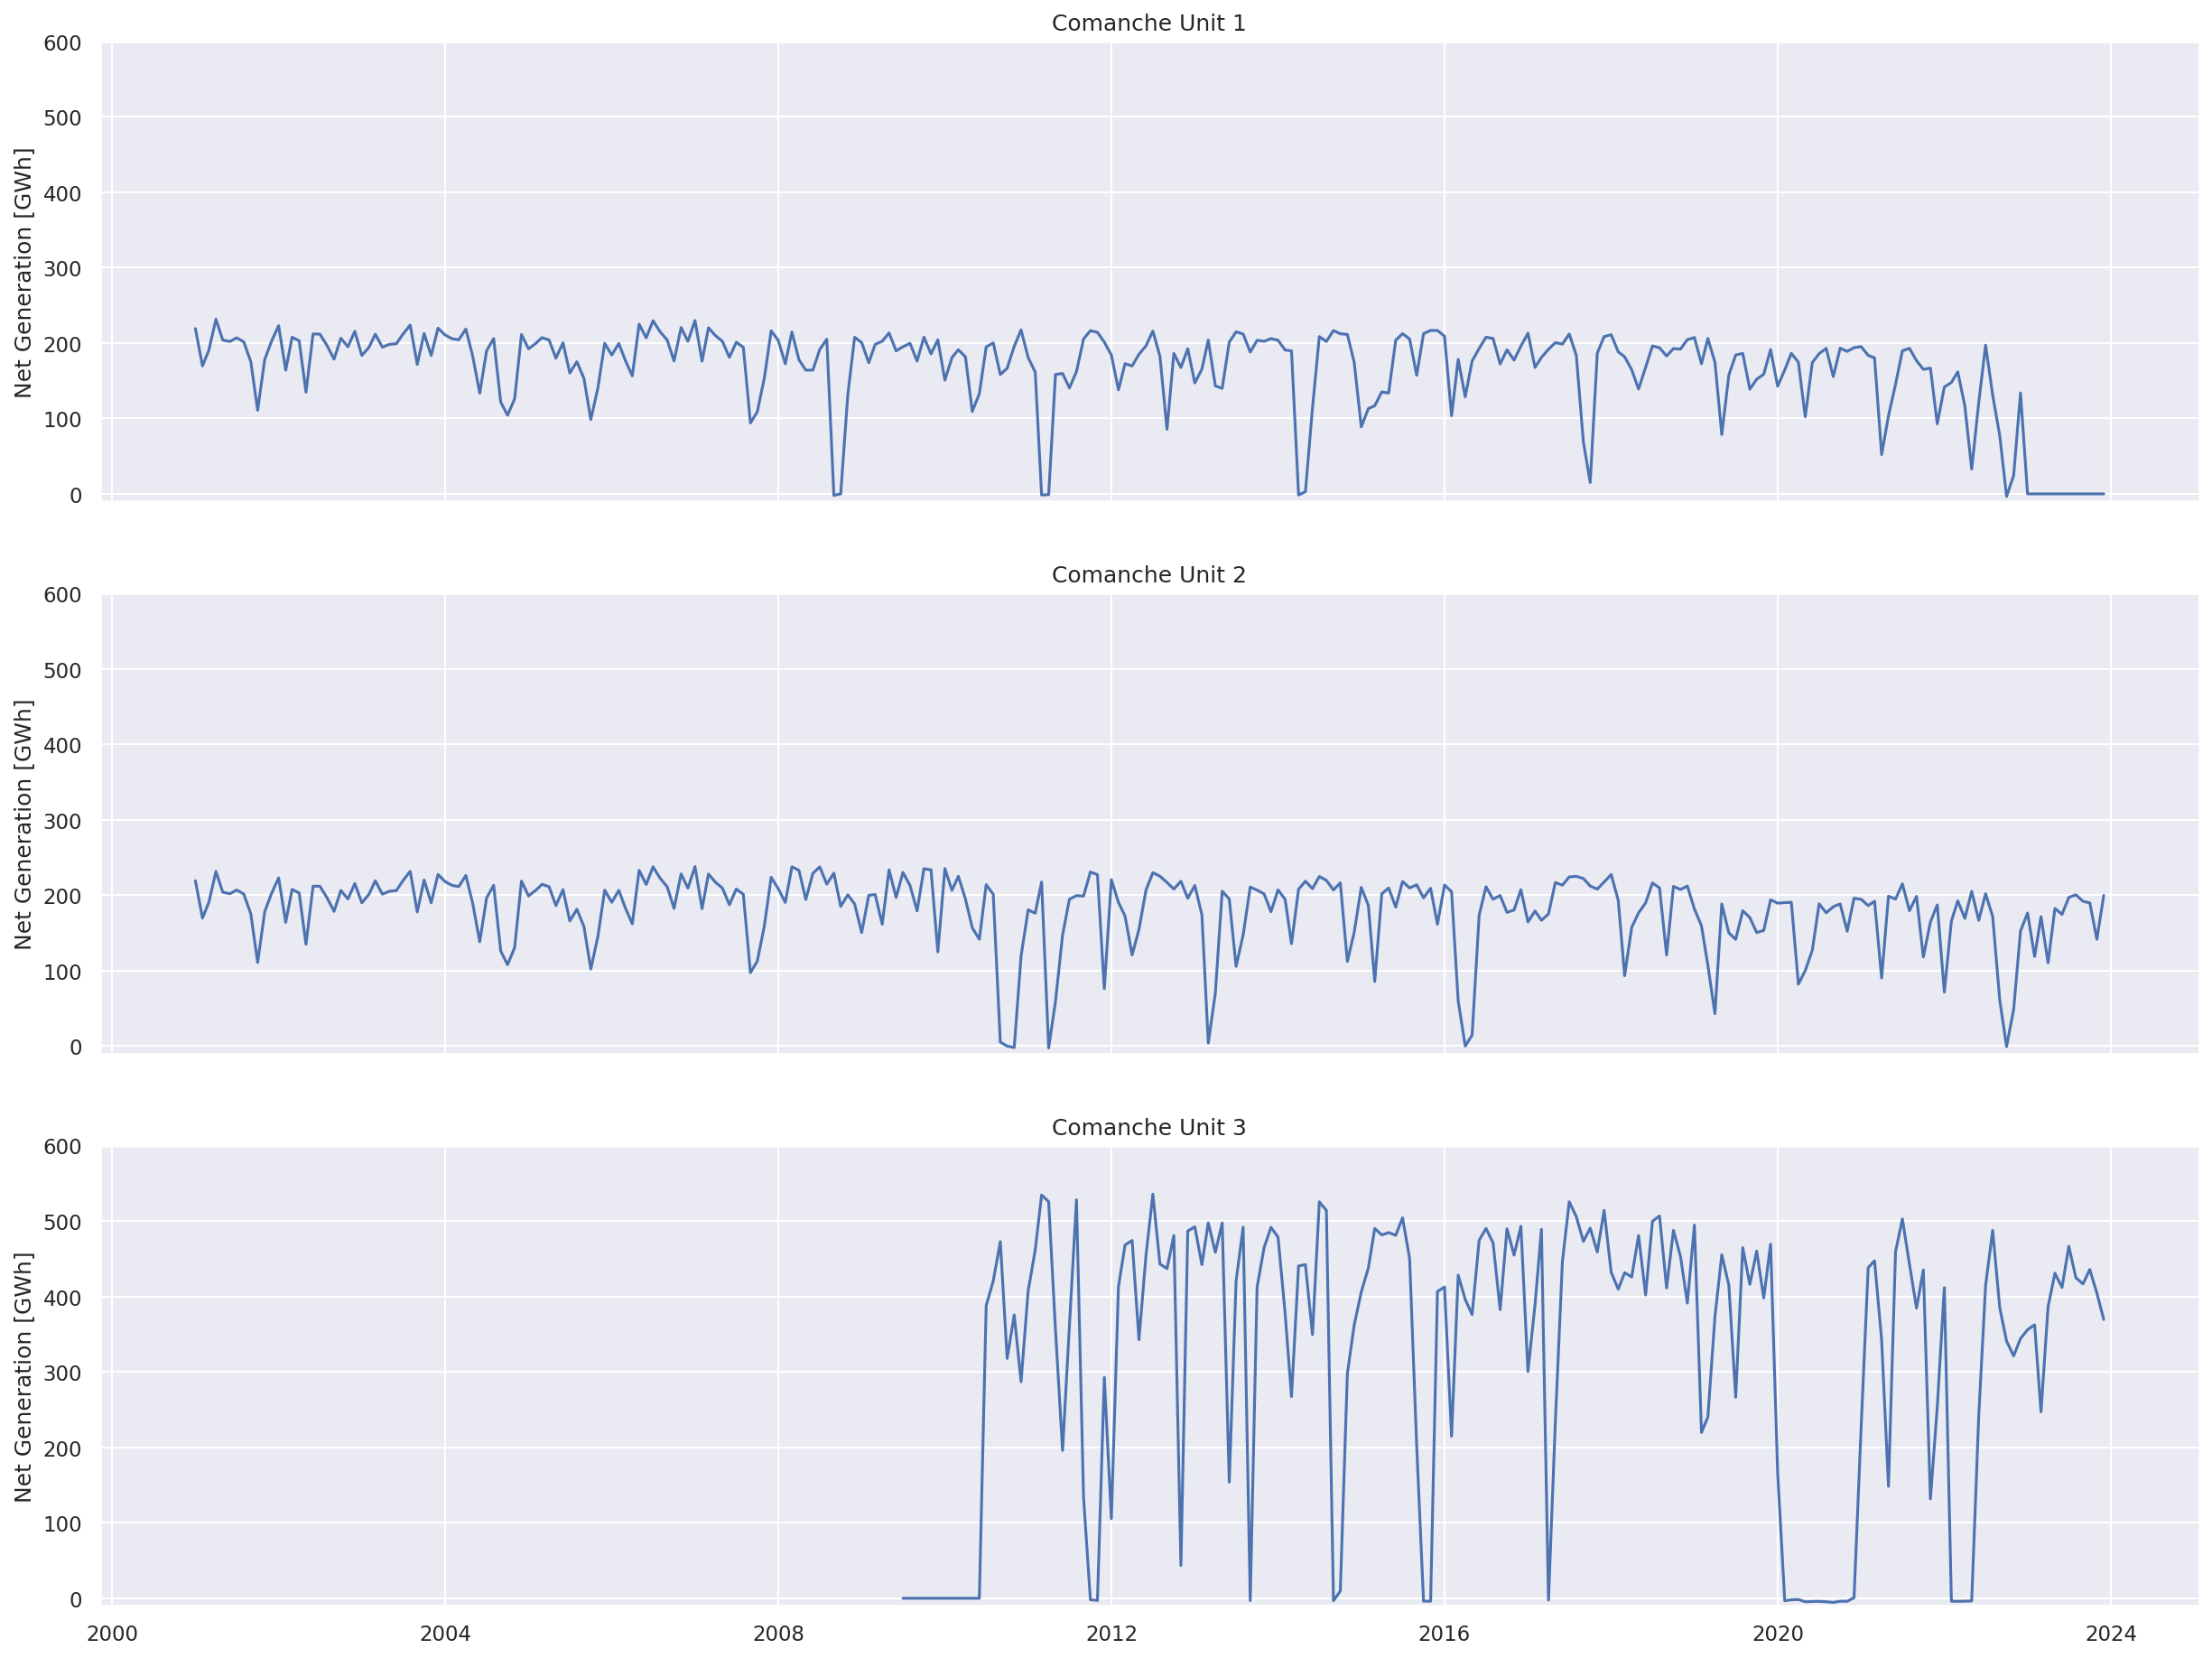

In [9]:
gen_ids = ["1", "2", "3"]
fig, axs = plt.subplots(nrows=len(gen_ids), ncols=1, sharex=True, figsize=(20,15))
for n, gen_id in enumerate(gen_ids):
    axs[n].plot(
        pd.to_datetime(comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "report_date"]),
        comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "net_generation_mwh"] / 1000.0,
    )
    axs[n].set_ylim(-10, 600)
    axs[n].set_title(f"Comanche Unit {gen_id}")
    axs[n].set_ylabel("Net Generation [GWh]")
plt.show();

## Monthly Fuel Costs per MWh

Fuel costs are reported for each fuel type of a plant. We allocate costs to the generator level based on net generation. To do this, we assume that each generator has the same fuel mix.

- Overall coal prices have been pretty stable.
- Unit 1 appears to have slightly higher fuel costs per MWh
- Spikes in per-MWh fuel costs are due to the fact that monthly fuel costs are based on fuel deliveries, which may still take place even if the plant is not operating.
- Note that the anomolously low fuel costs for 2016 that were present in the FERC Form 1 data above do not appear in the EIA data.

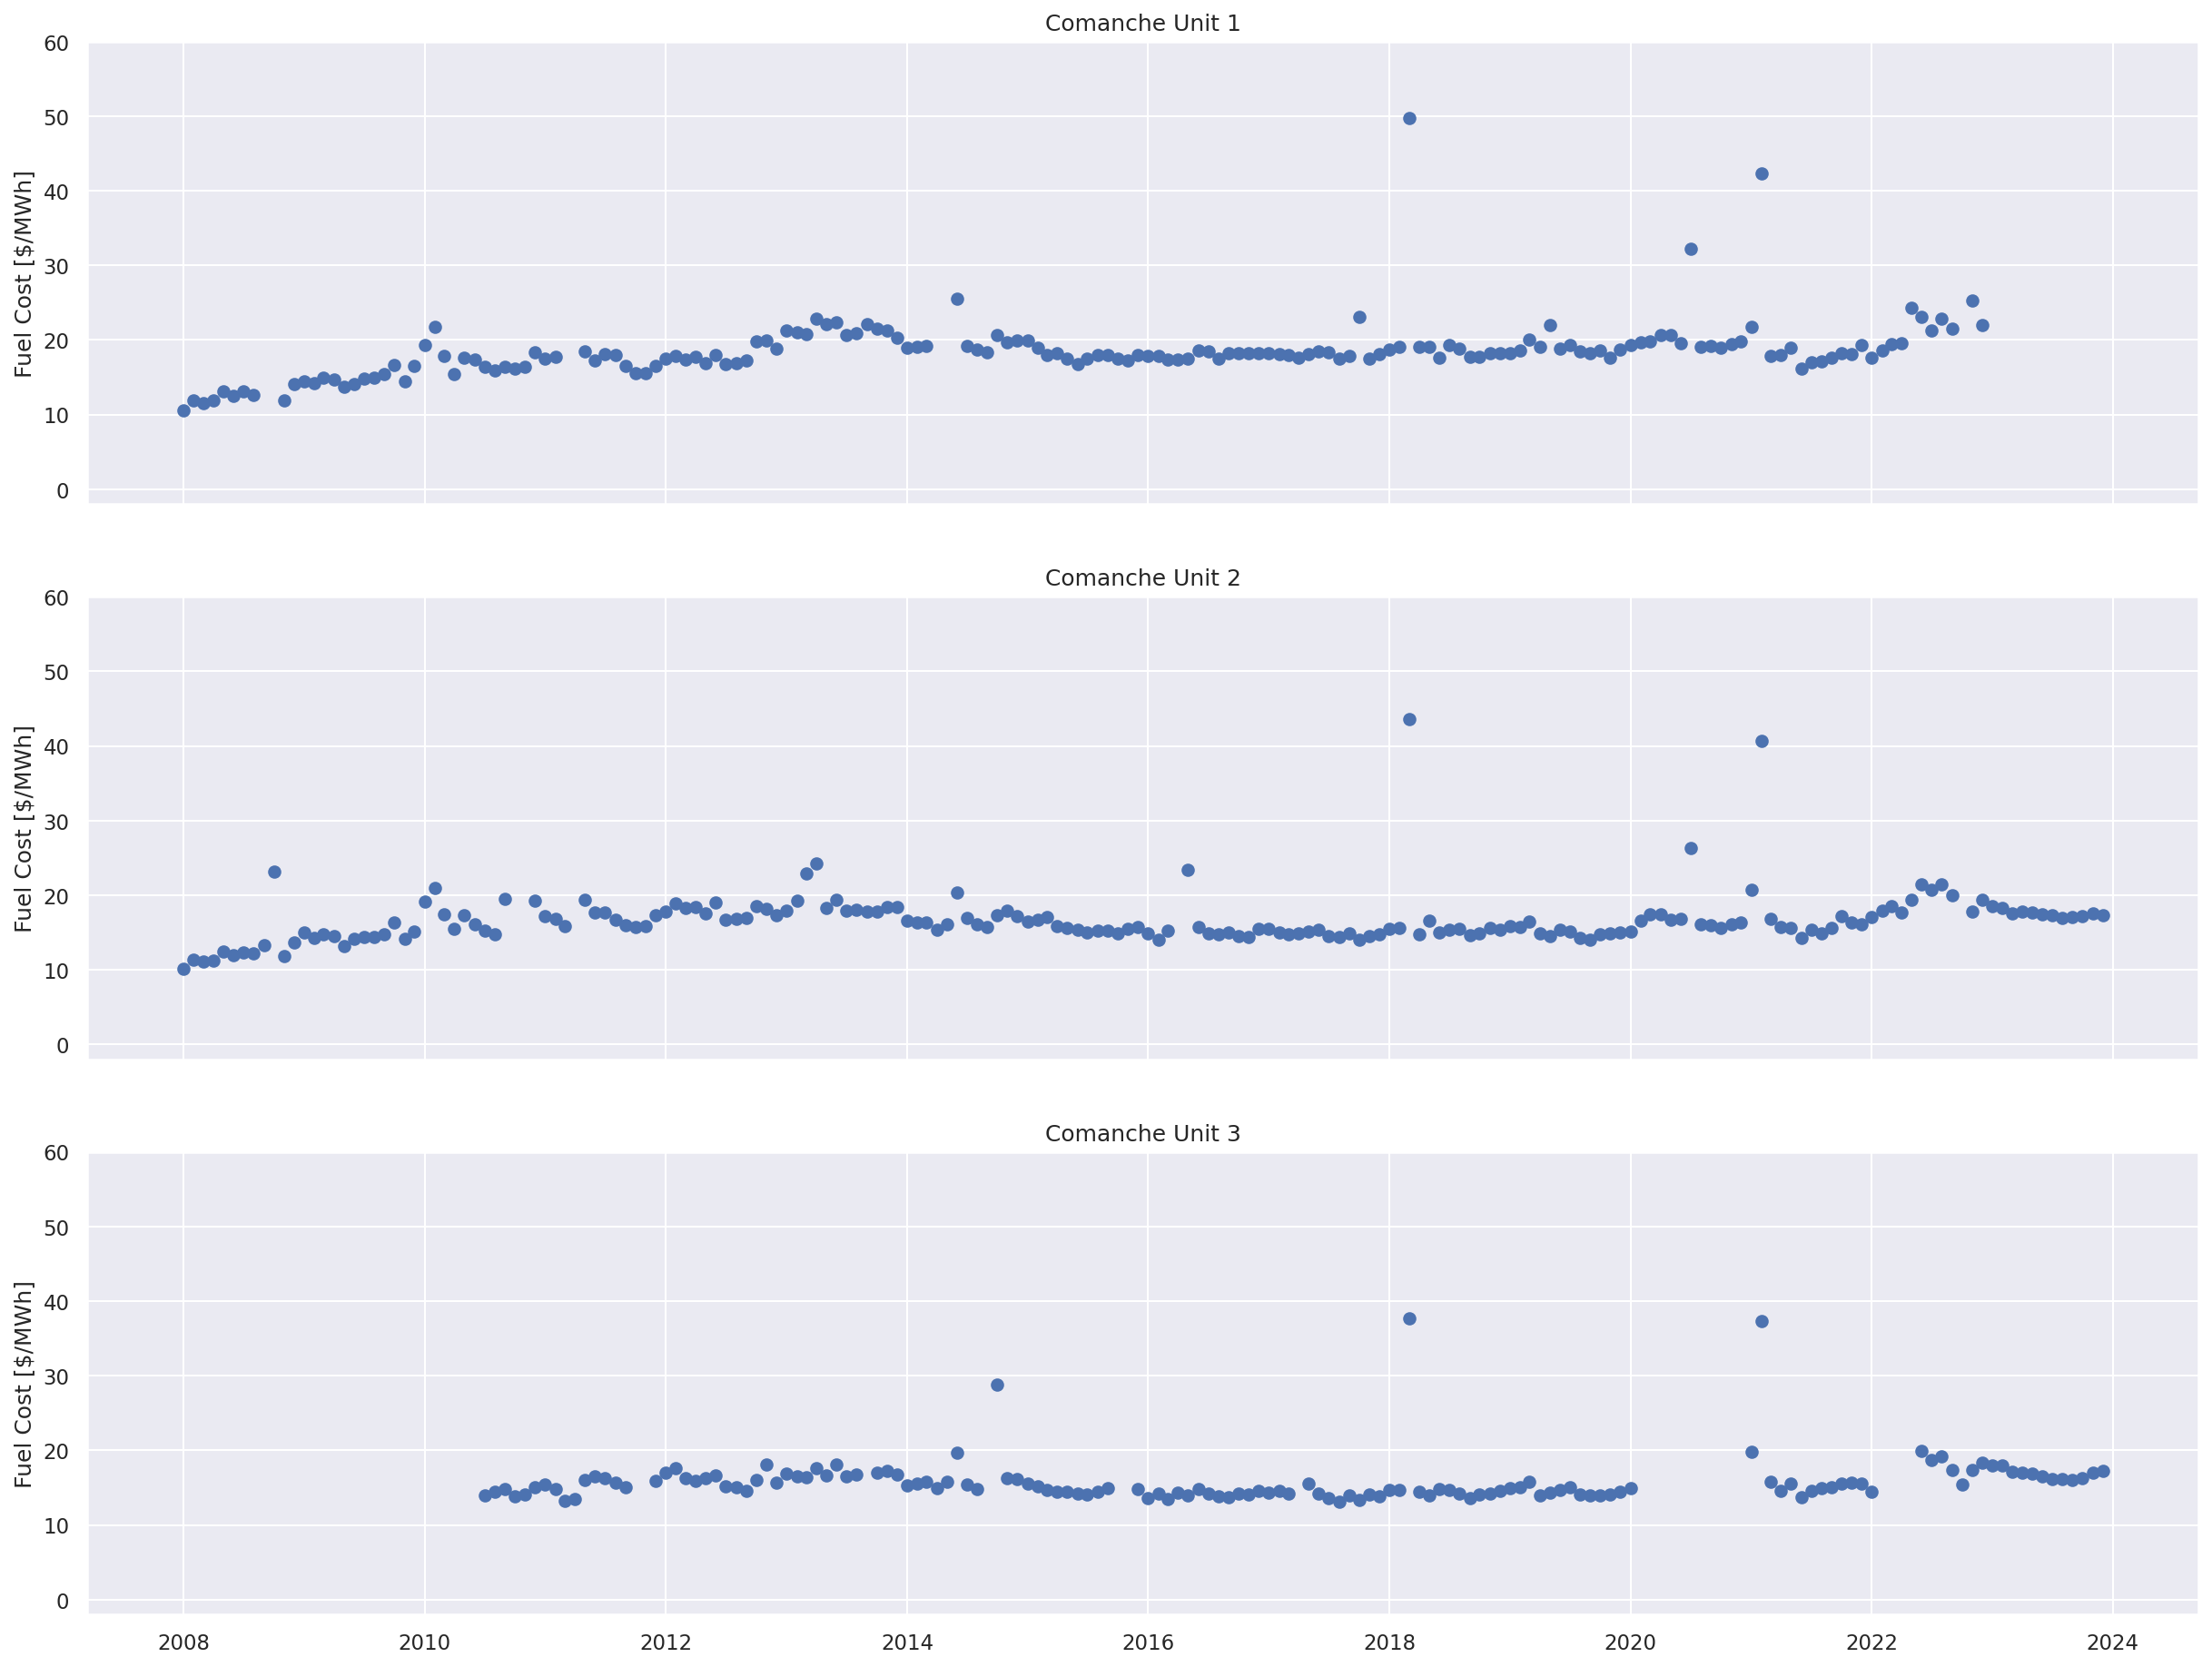

In [10]:
gen_ids = ["1", "2", "3"]
fig, axs = plt.subplots(nrows=len(gen_ids), ncols=1, sharex=True, figsize=(20,15))
for n, gen_id in enumerate(gen_ids):
    axs[n].scatter(
        pd.to_datetime(comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "report_date"]),
        comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "fuel_cost_per_mwh"],
    )
    axs[n].set_ylim(-2, 60)
    axs[n].set_title(f"Comanche Unit {gen_id}")
    axs[n].set_ylabel("Fuel Cost [$/MWh]")
plt.show();

## Monthly Average Heat Rates

These are calculated at the unit level using unit-level net generation and fuel consumption.

- The higher estimated heat rate for Unit 1 is likely the cause of higher fuel cost estimates above.

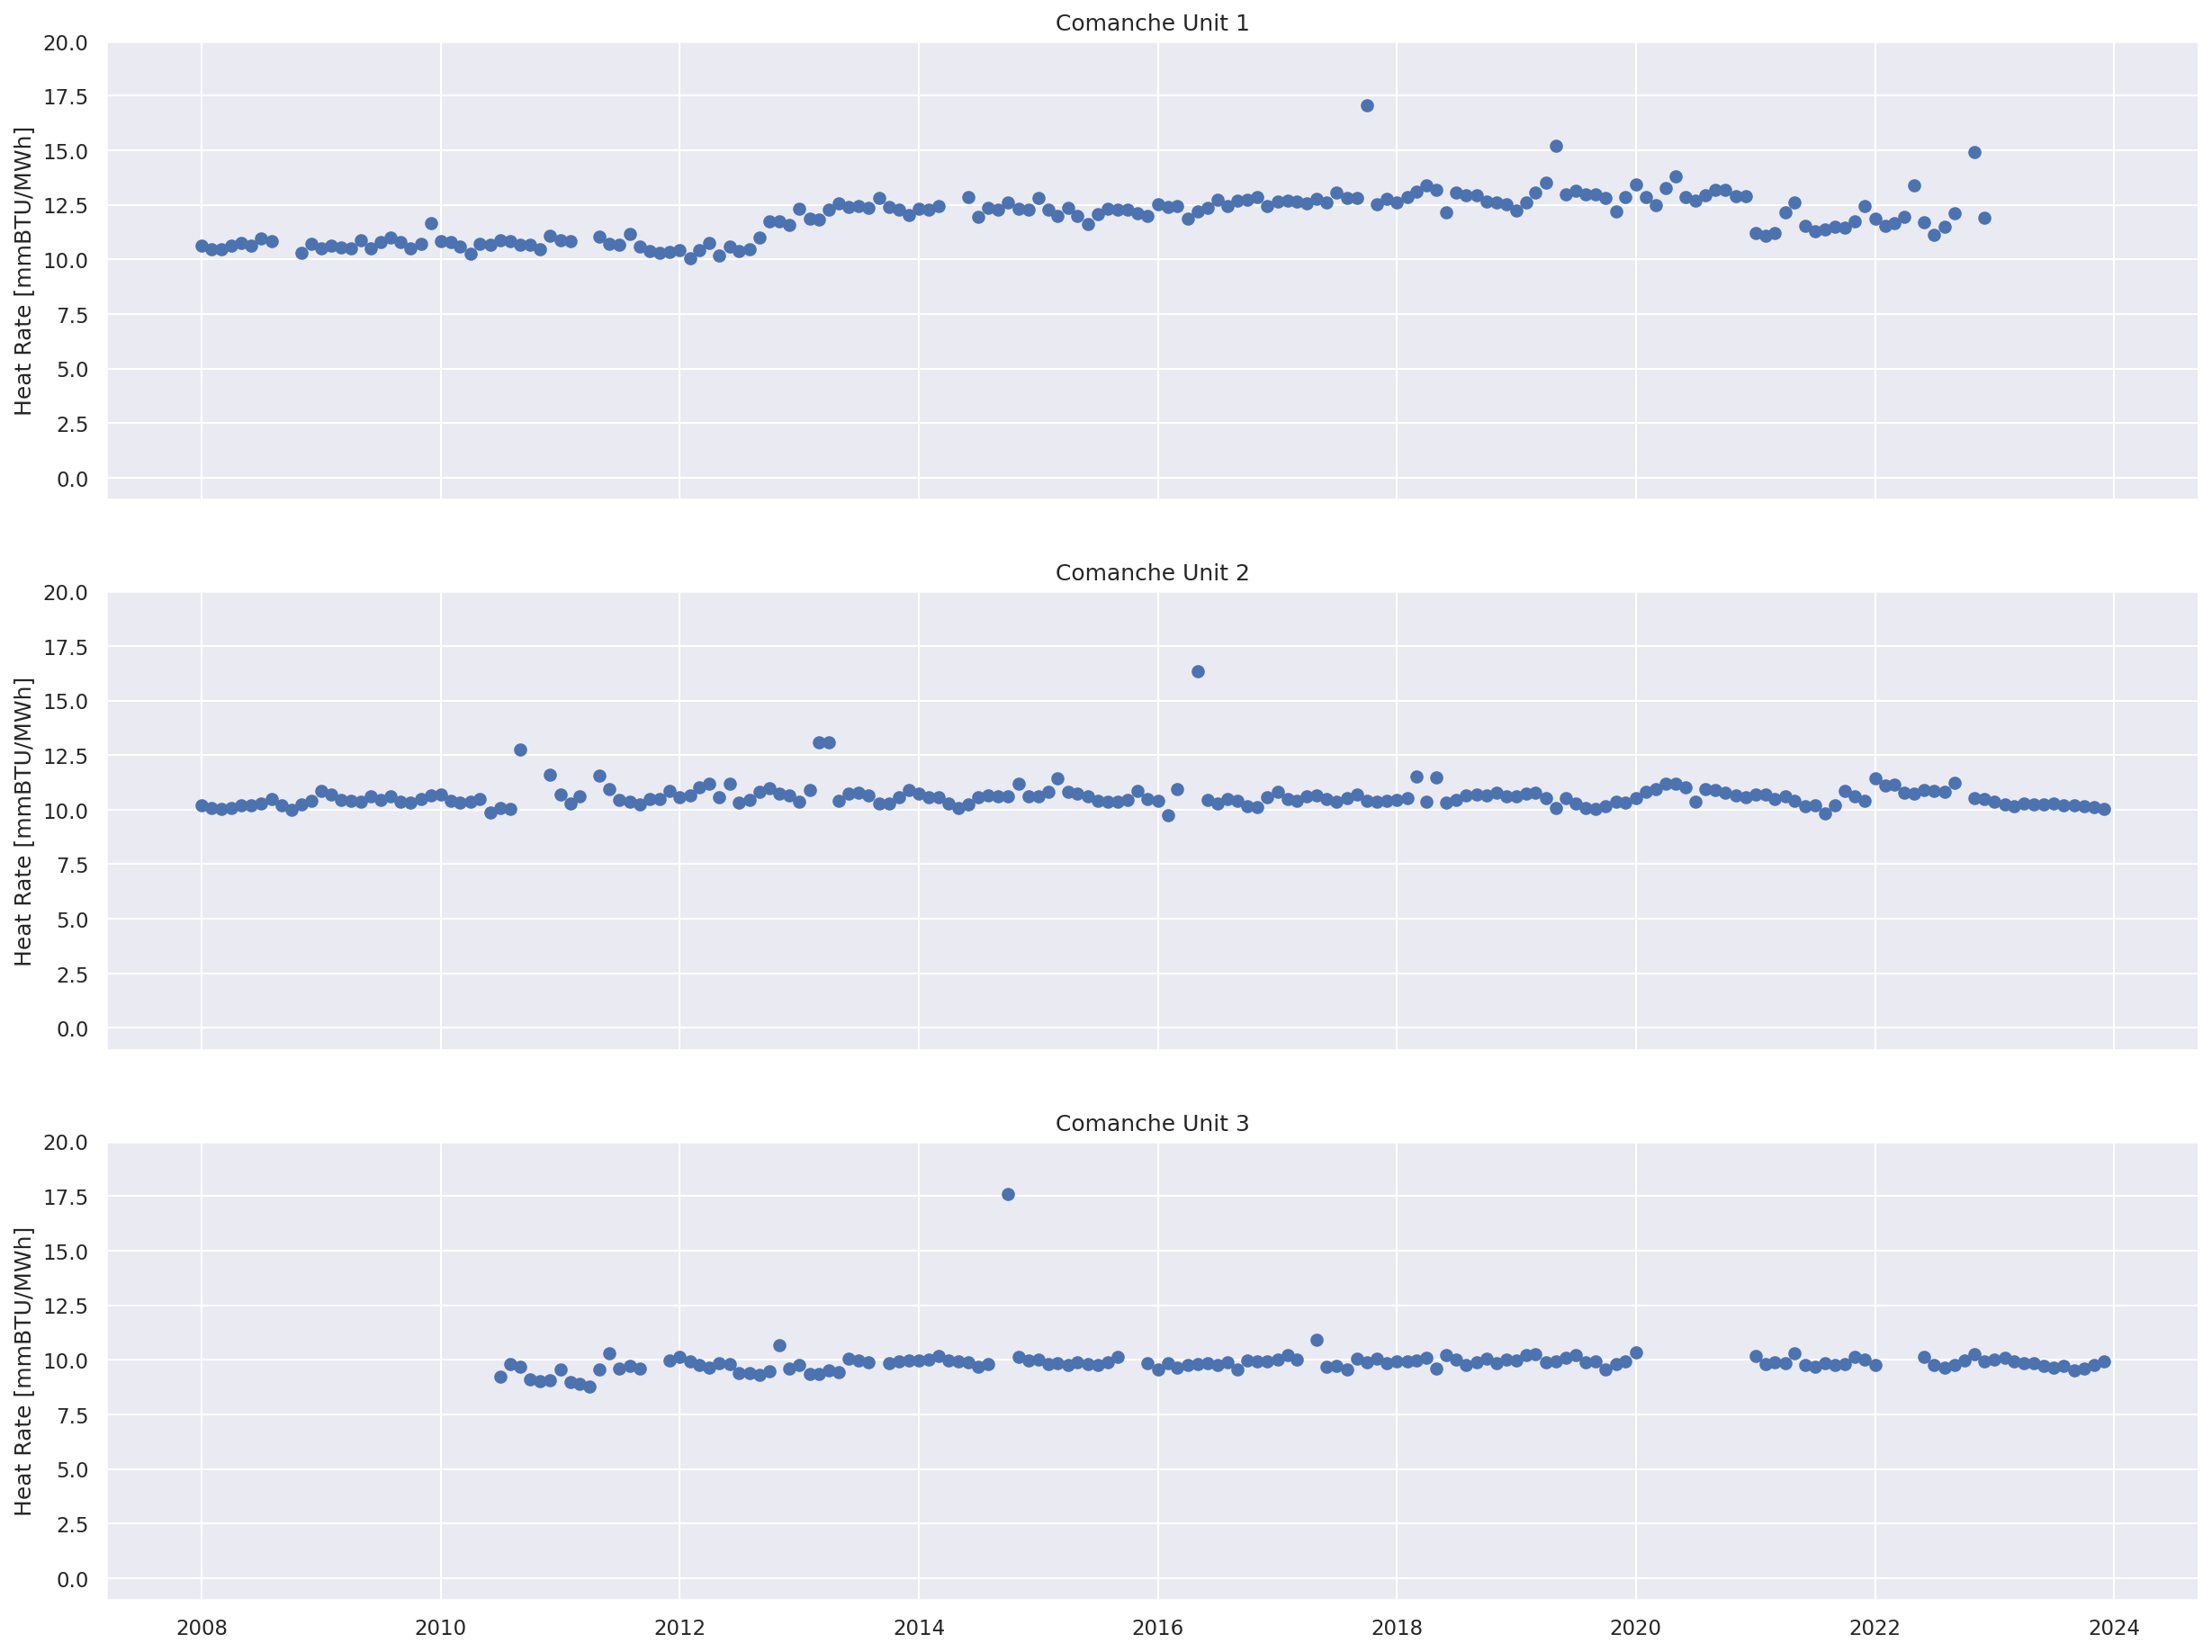

In [11]:
gen_ids = ["1", "2", "3"]
fig, axs = plt.subplots(nrows=len(gen_ids), ncols=1, sharex=True, figsize=(20,15))
for n, gen_id in enumerate(gen_ids):
    axs[n].scatter(
        pd.to_datetime(comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "report_date"]),
        comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "unit_heat_rate_mmbtu_per_mwh"],
    )
    axs[n].set_ylim(-1, 20)
    axs[n].set_title(f"Comanche Unit {gen_id}")
    axs[n].set_ylabel("Heat Rate [mmBTU/MWh]")
plt.show();

## Monthly Capacity Factor

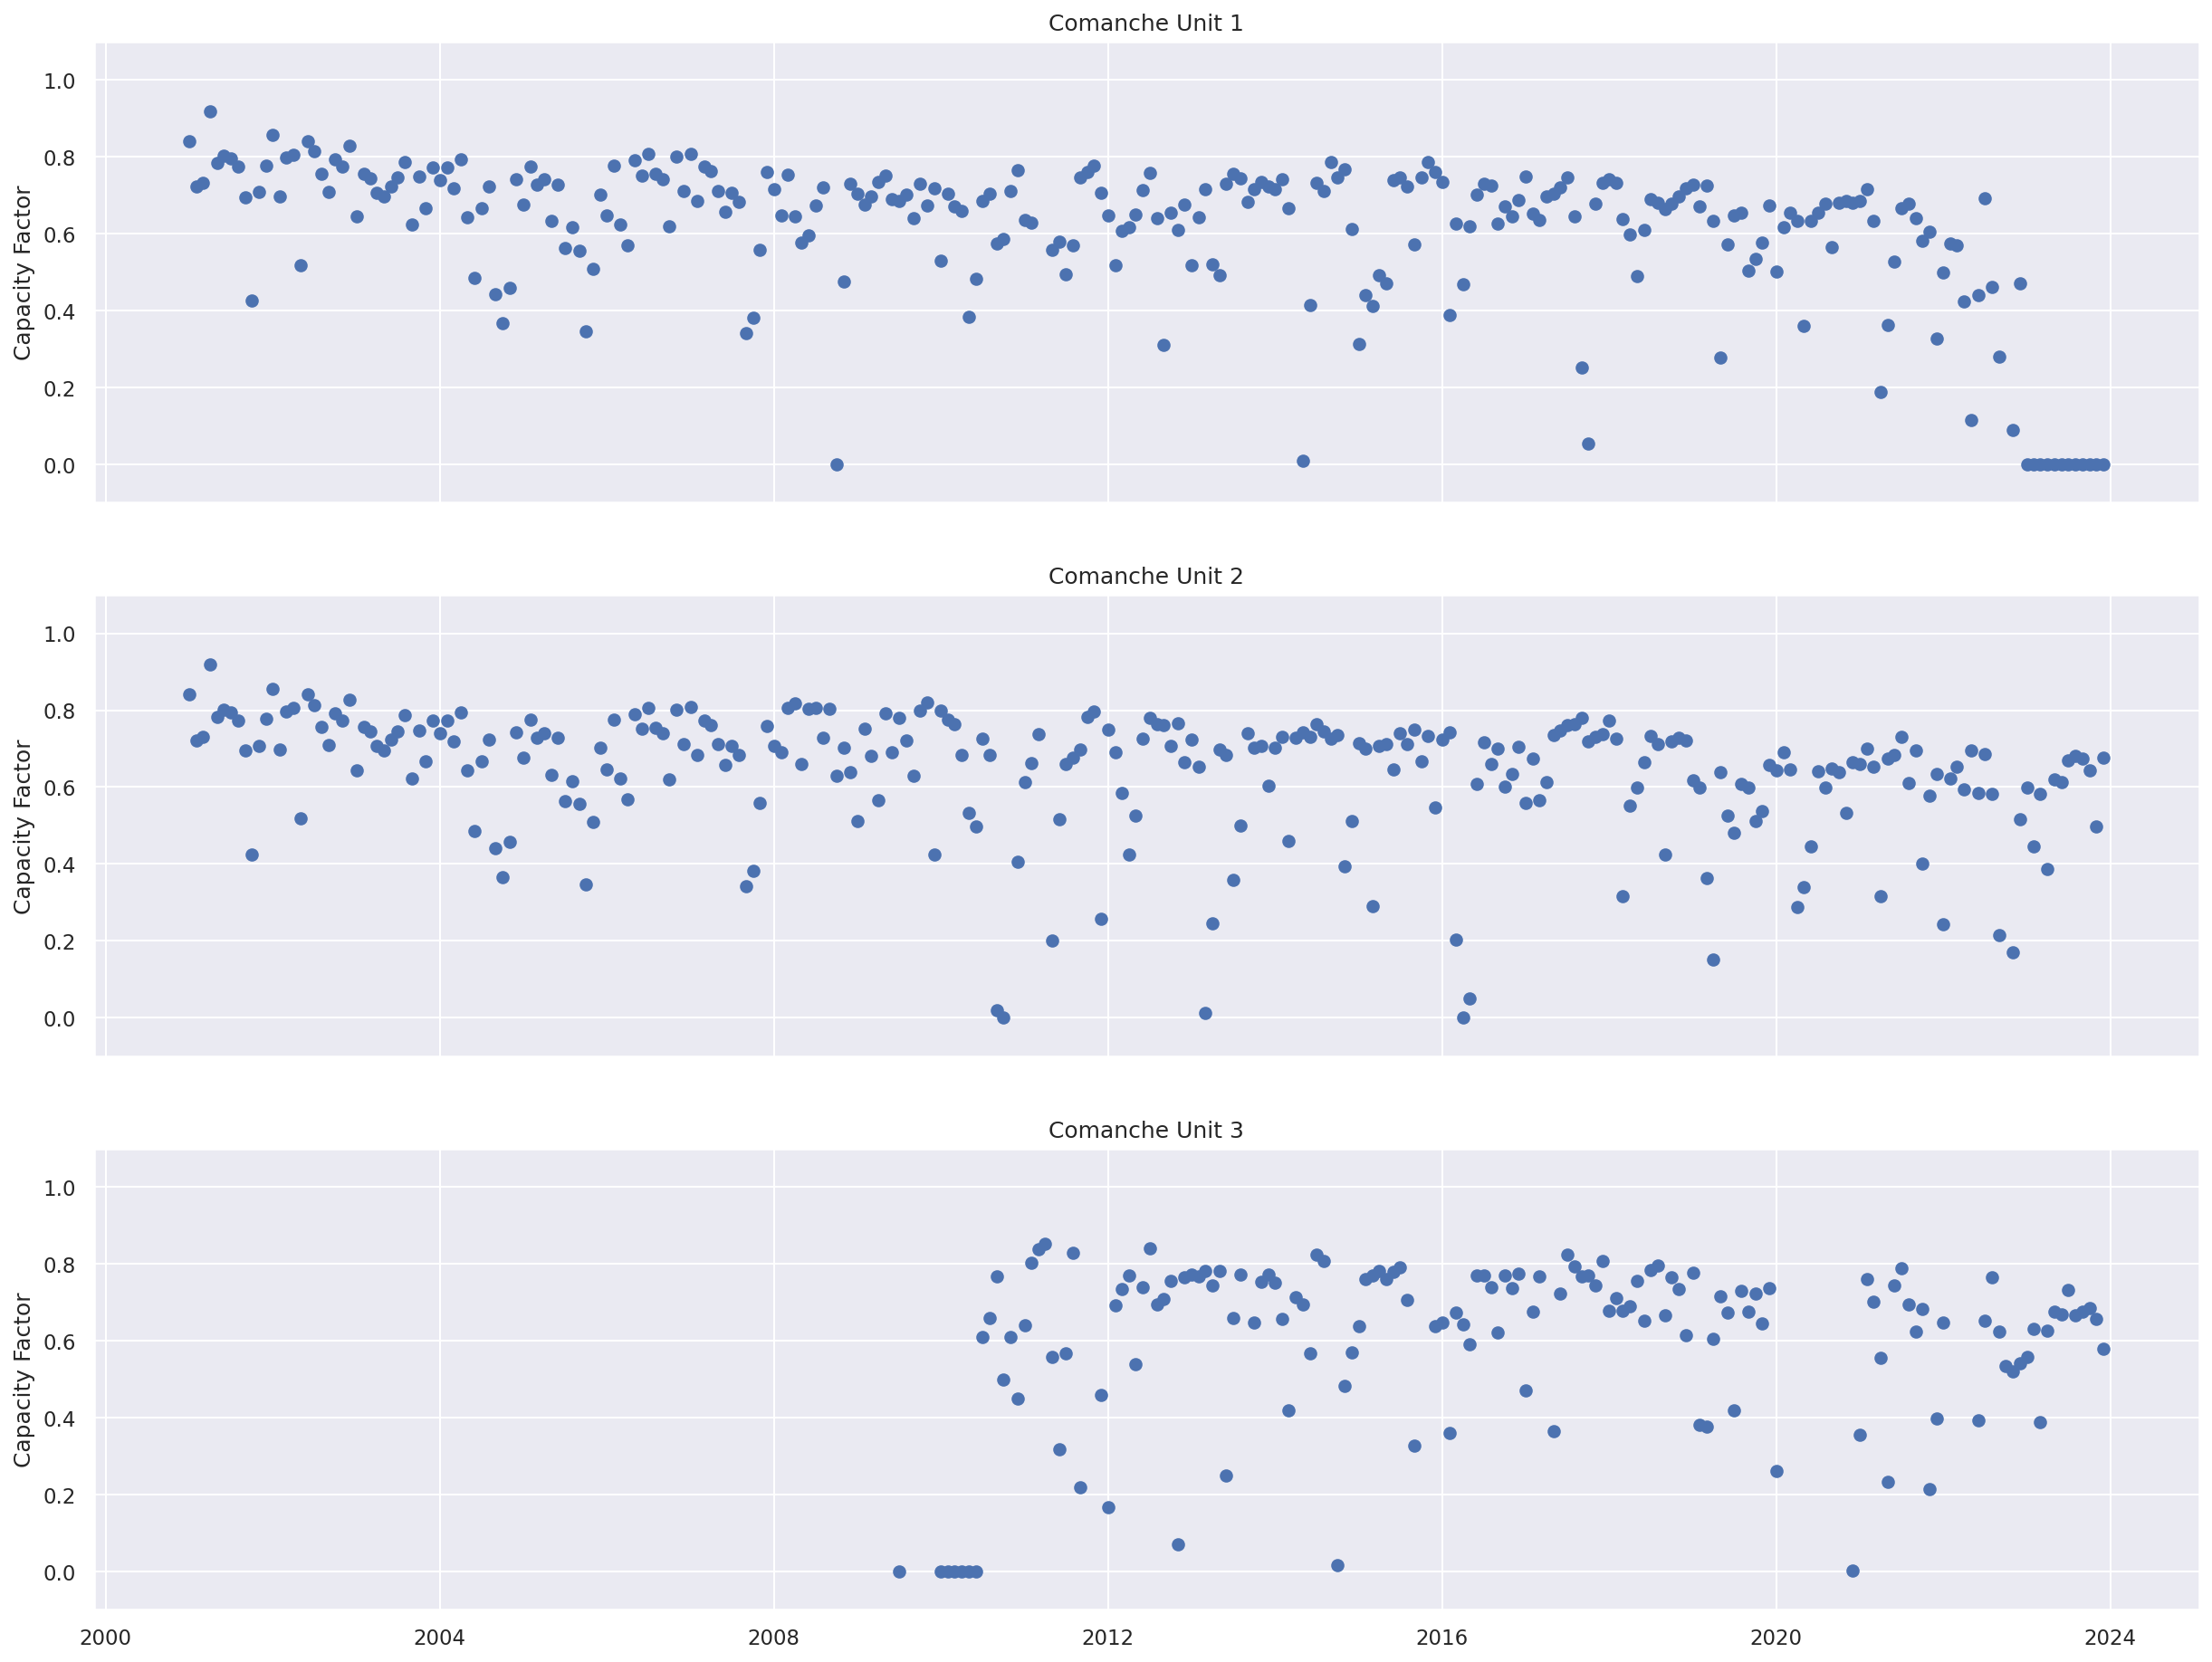

In [12]:
gen_ids = ["1", "2", "3"]
fig, axs = plt.subplots(nrows=len(gen_ids), ncols=1, sharex=True, figsize=(20,15))
for n, gen_id in enumerate(gen_ids):
    axs[n].scatter(
        pd.to_datetime(comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "report_date"]),
        comanche_mcoe.loc[comanche_mcoe.generator_id == gen_id, "capacity_factor"],
    )
    axs[n].set_ylim(-0.1, 1.1)
    axs[n].set_title(f"Comanche Unit {gen_id}")
    axs[n].set_ylabel("Capacity Factor")
plt.show();

Some observations:
* Note the downtime period in 2020 for Comanche 3.

In [13]:
comanche_mcoe[comanche_mcoe.generator_id=="3"]

plant_id_eia generator_id report_date  unit_id_pudl  plant_id_pudl  \
723           470            3  2005-01-01          <NA>            126   
724           470            3  2006-01-01          <NA>            126   
725           470            3  2007-01-01          <NA>            126   
726           470            3  2008-01-01          <NA>            126   
384           470            3  2009-07-01             3            126   
..            ...          ...         ...           ...            ...   
549           470            3  2023-09-01             3            126   
550           470            3  2023-10-01             3            126   
551           470            3  2023-11-01             3            126   
552           470            3  2023-12-01             3            126   
727           470            3  2024-01-01          <NA>            126   

    plant_name_eia  utility_id_eia  utility_id_pudl  \
723       Comanche           15466              272   
724       Comanche           15466              272   
725       Comanche           15466              272   
726       Comanche           15466              272   
384       Comanche           15466              272   
..             ...             ...              ...   
549       Comanche           15466              272   
550       Comanche           15466              272   
551       Comanche           15466              272   
552       Comanche           15466              272   
727       Comanche           15466              272   

                  utility_name_eia   technology_description  \
723  Public Service Co of Colorado  Conventional Steam Coal   
724  Public Service Co of Colorado  Conventional Steam Coal   
725  Public Service Co of Colorado  Conventional Steam Coal   
726  Public Service Co of Colorado  Conventional Steam Coal   
384  Public Service Co of Colorado  Conventional Steam Coal   
..                             ...                      ...   
549  Public Service Co of Colorado  Conventional Steam Coal   
550  Public Service Co of Colorado  Conventional Steam Coal   
551  Public Service Co of Colorado  Conventional Steam Coal   
552  Public Service Co of Colorado  Conventional Steam Coal   
727  Public Service Co of Colorado  Conventional Steam Coal   

    energy_source_code_1 prime_mover_code generator_operating_date  \
723                  SUB               ST               2010-07-01   
724                  SUB               ST               2010-07-01   
725                  SUB               ST               2010-07-01   
726                  SUB               ST               2010-07-01   
384                  SUB               ST               2010-07-01   
..                   ...              ...                      ...   
549                  SUB               ST               2010-07-01   
550                  SUB               ST               2010-07-01   
551                  SUB               ST               2010-07-01   
552                  SUB               ST               2010-07-01   
727                  SUB               ST               2010-07-01   

    generator_retirement_date operational_status  capacity_mw  \
723                      <NA>           proposed   820.000000   
724                      <NA>           proposed   820.000000   
725                      <NA>           proposed   820.000000   
726                      <NA>           proposed   856.799988   
384                      <NA>           proposed   856.799988   
..                        ...                ...          ...   
549                      <NA>           existing   856.799988   
550                      <NA>           existing   856.799988   
551                      <NA>           existing   856.799988   
552                      <NA>           existing   856.799988   
727                      <NA>           existing   856.799988   

    fuel_type_code_pudl planned_generator_retirement_date  capac

# Read Hourly Generation & Emissions Data from Apache Parquet
* The full hourly emissions time series for thousands of US power plants covering 1995-2022 contains almost a billion records.
* The data is stored in a single [Apache Parquet file](https://parquet.apache.org/) with row-groups defined by year and state.
* This compressed columnar format enables very efficient queries with appropriate tooling, including [Dask](https://www.dask.org/) and [PyArrow](https://arrow.apache.org/docs/python/index.html).
* Reading the entire dataset into memory at once will probably exceed the available RAM.
* Other tools like [DuckDB](https://duckdb.org/docs/data/parquet/overview.html) ([Python API](https://duckdb.org/docs/api/python/overview)) also provide good Parquet support. 

In [14]:
%%time
from dask import dataframe as dd

unit_ids = ["1", "2", "3"]
cems_cols = [
    "operating_datetime_utc",
    "plant_id_eia",
    "plant_id_epa",
    "emissions_unit_id_epa",
    "operating_time_hours",
    "gross_load_mw",
    "heat_content_mmbtu",
    "co2_mass_tons",
]

## dd is dask.dataframe
comanche_cems_dd = dd.read_parquet(
    f"{pudl_path}/pudl_parquet/core_epacems__hourly_emissions.parquet",
    engine="pyarrow",
    filters=[
        ("state", "=", "CO"),
        ("plant_id_eia", "=", 470),
    ],
    columns=cems_cols,
    index=False,
)
comanche_cems = (
    comanche_cems_dd.compute()
    .assign(
        gross_generation_mwh=lambda x: x.operating_time_hours * x.gross_load_mw,
        heat_rate_mmbtu_per_mwh=lambda x: x.heat_content_mmbtu / x.gross_generation_mwh,
        gross_co2_intensity=lambda x: x.co2_mass_tons / x.gross_generation_mwh
    )
)
comanche_cems.info()

<class 'pandas.core.frame.DataFrame'>
Index: 596016 entries, 0 to 26255
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   operating_datetime_utc   596016 non-null  datetime64[ms]
 1   plant_id_eia             596016 non-null  int32         
 2   plant_id_epa             596016 non-null  int32         
 3   emissions_unit_id_epa    596016 non-null  string        
 4   operating_time_hours     595732 non-null  float32       
 5   gross_load_mw            506009 non-null  float32       
 6   heat_content_mmbtu       506009 non-null  float32       
 7   co2_mass_tons            506009 non-null  float32       
 8   gross_generation_mwh     506009 non-null  float32       
 9   heat_rate_mmbtu_per_mwh  505997 non-null  float32       
 10  gross_co2_intensity      505931 non-null  float32       
dtypes: datetime64[ms](1), float32(7), int32(2), string(1)
memory usage: 34.7 MB
CPU time

## Power Output
- The scatter plots below contain more than half a million points.
- They show the operational patterns of the 3 Comanche units at hourly resolution.
- Clear upper and lower bounds on plant operating output are visible, with Unit 3 typically operating between 510 and 800 MW.
- Note that even though Units 1 & 2 are ~50 years old (they came online in 1973 and 1975, respectively) they seem to be up and running more frequently than the brand-new Unit 3.
- In particular, Unit 3 spent most of 2020 offline, and since experienced multiple months-long periods of downtime.
- Because Unit 3 is more than 50% of the overall plant's generating capacity, these outages have had a huge impact in overall capacity factor, as we saw above in the FERC Form 1 capacity factor data.

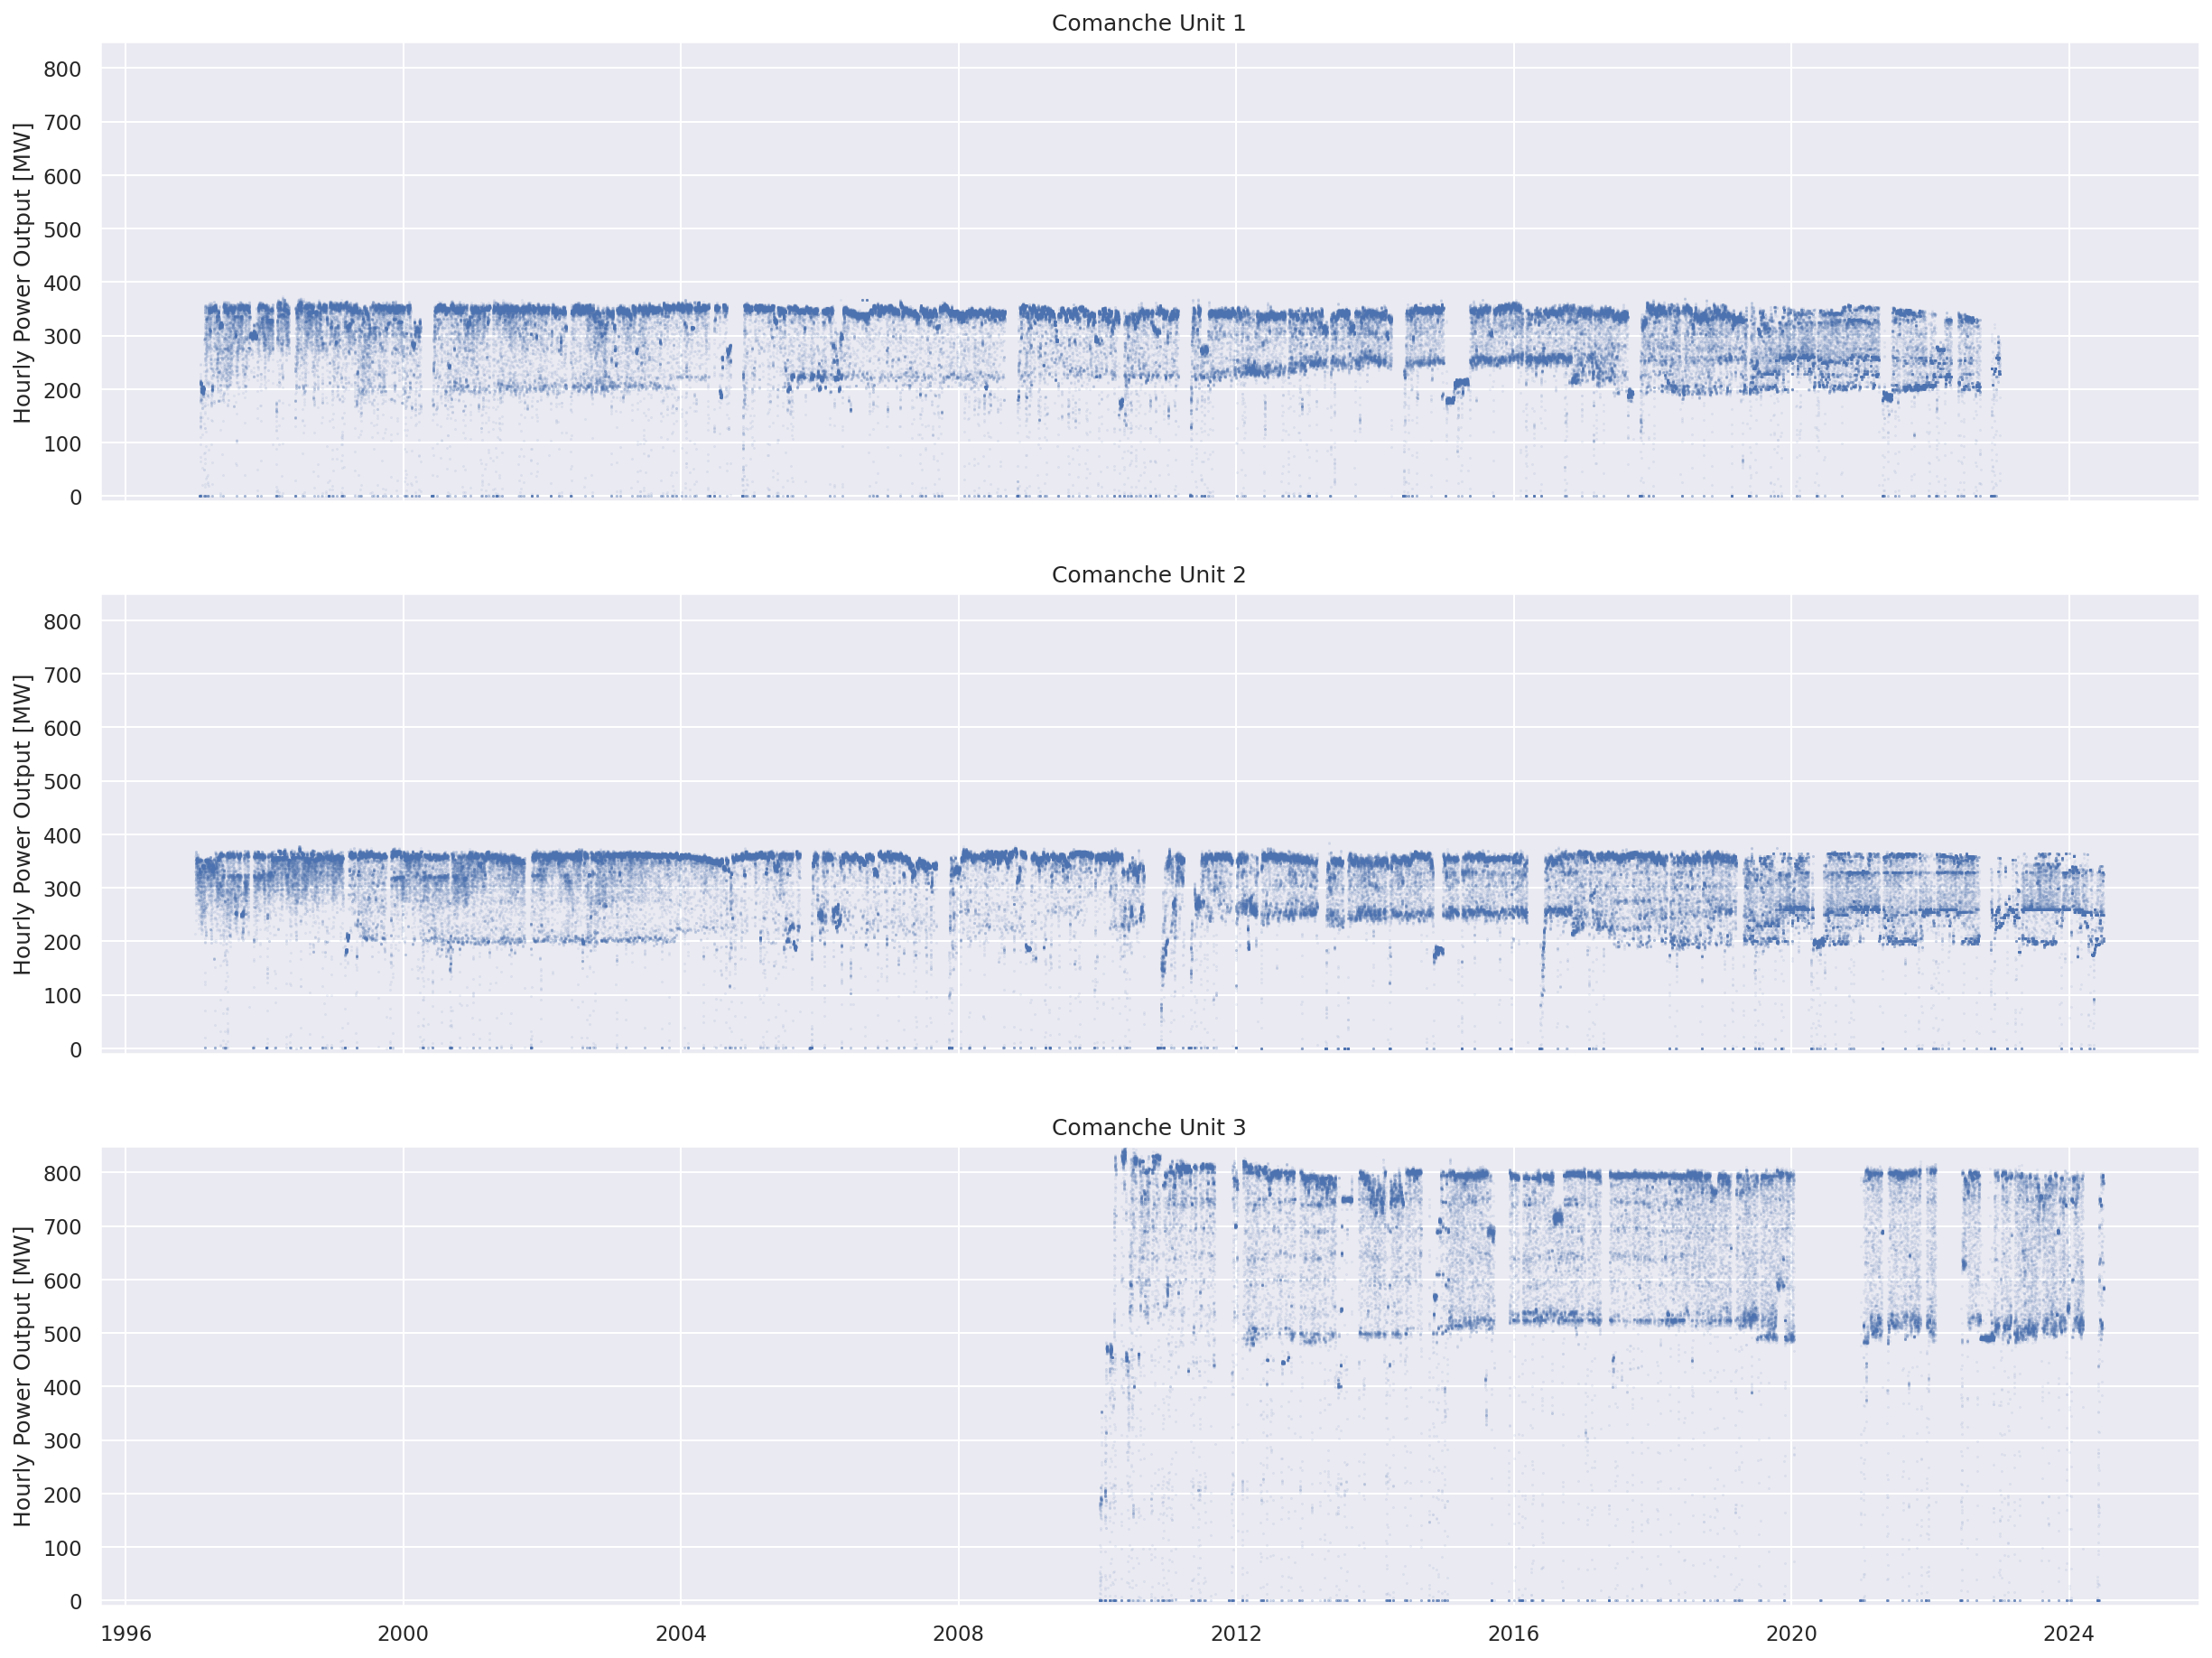

In [15]:
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, unit_id in enumerate(unit_ids):
    axs[n].scatter(
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "operating_datetime_utc"],
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "gross_generation_mwh"],
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(-10, 850)
    axs[n].set_title(f"Comanche Unit {unit_id}")
    axs[n].set_ylabel("Hourly Power Output [MW]")
plt.show();

## Fuel Consumption

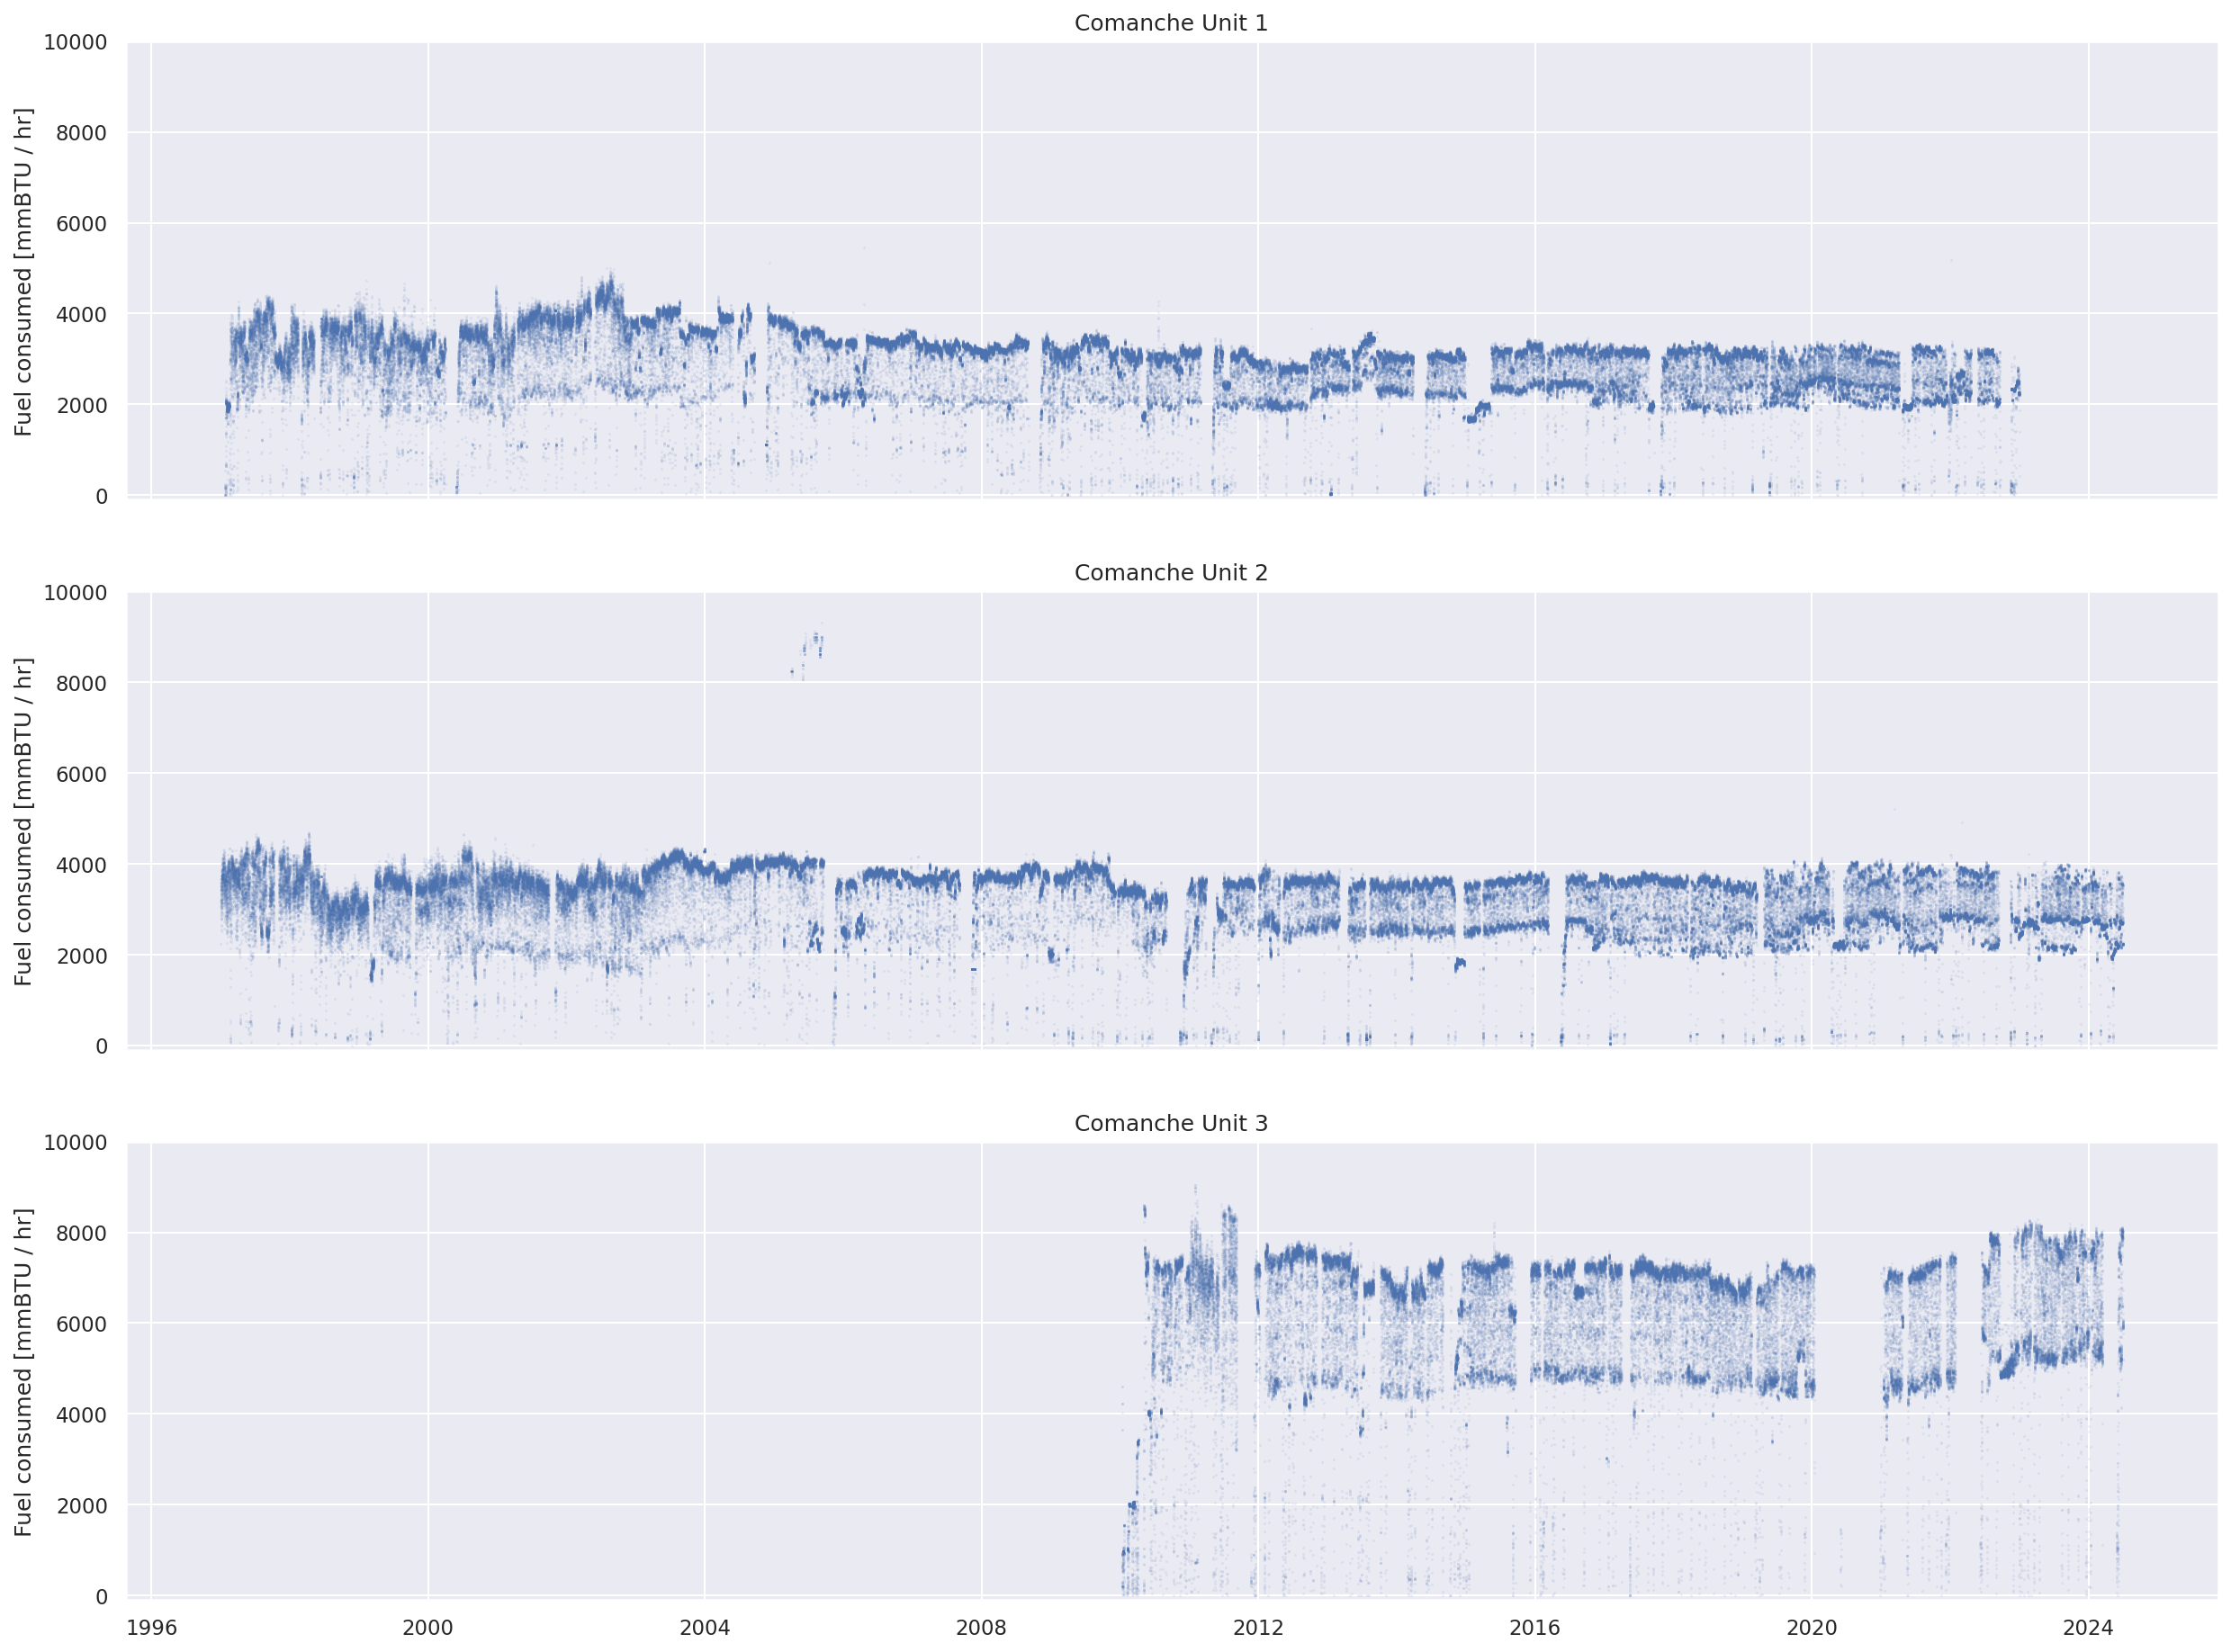

In [16]:
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, unit_id in enumerate(unit_ids):
    axs[n].scatter(
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "operating_datetime_utc"],
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "heat_content_mmbtu"],
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(-100,10_000)
    axs[n].set_title(f"Comanche Unit {unit_id}")
    axs[n].set_ylabel("Fuel consumed [mmBTU / hr]")
plt.show();

## Heat Rates

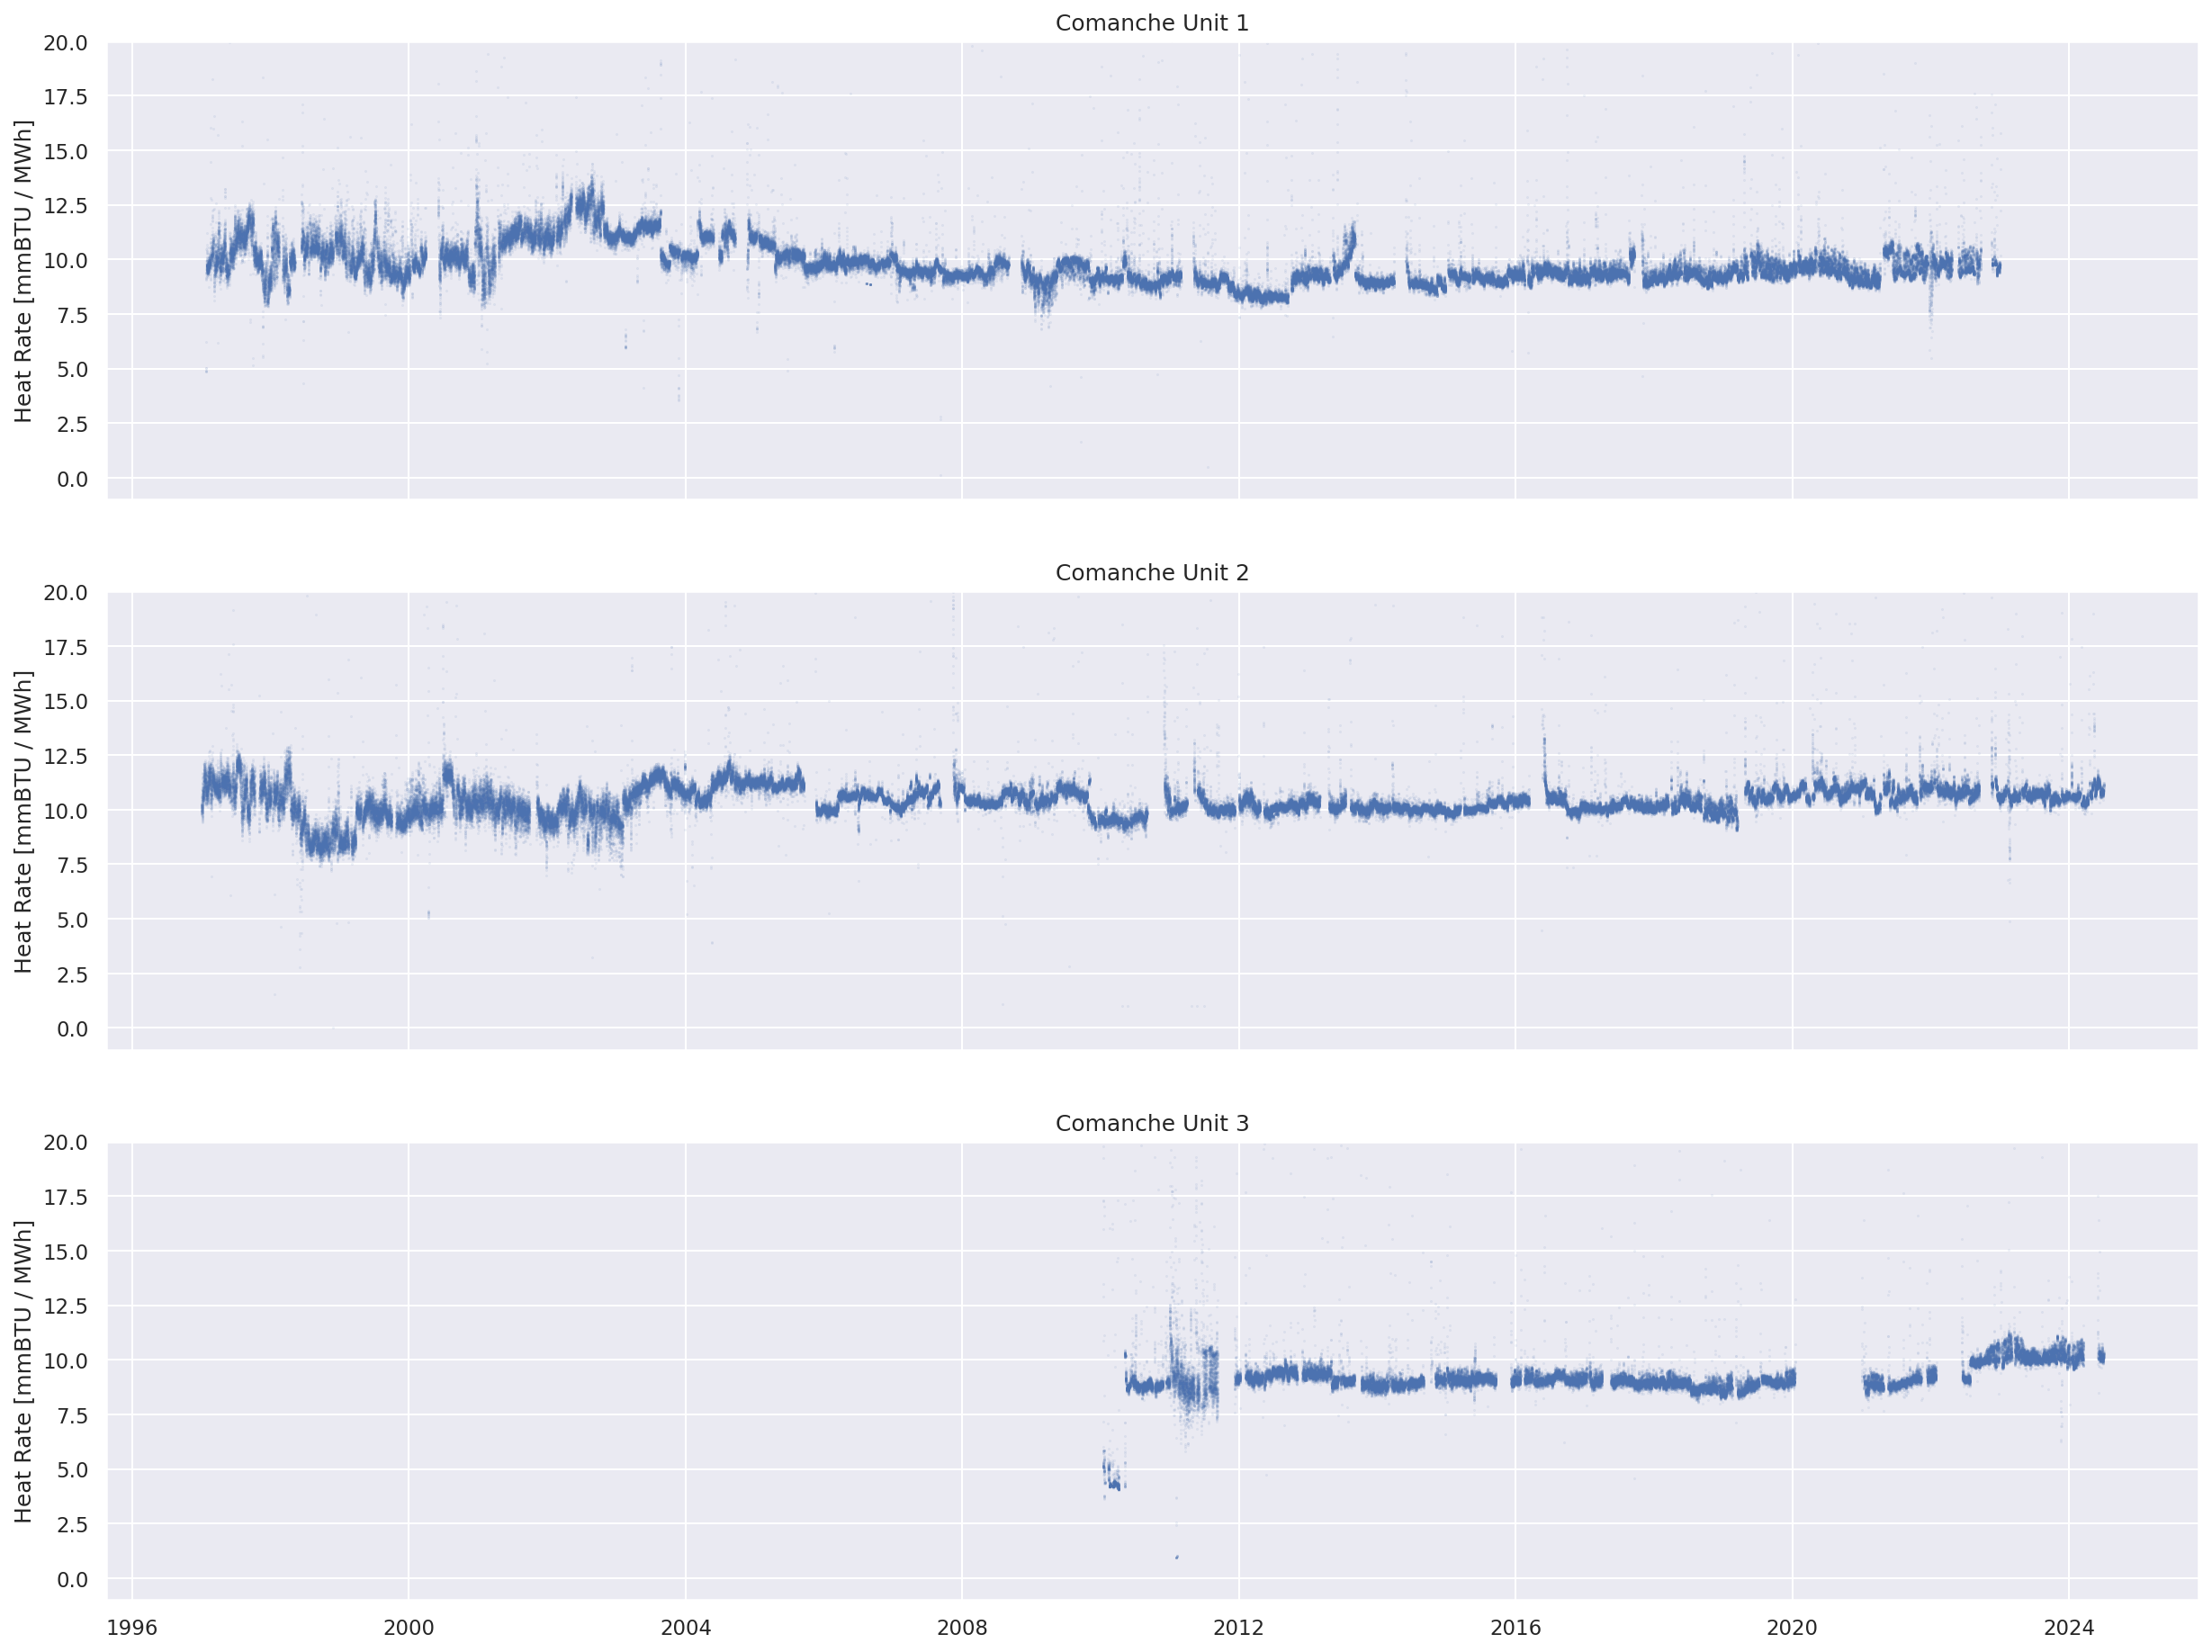

In [17]:
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, unit_id in enumerate(unit_ids):
    axs[n].scatter(
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "operating_datetime_utc"],
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "heat_rate_mmbtu_per_mwh"],
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(-1,20)
    axs[n].set_title(f"Comanche Unit {unit_id}")
    axs[n].set_ylabel("Heat Rate [mmBTU / MWh]")
plt.show();

## Emissions Intensity

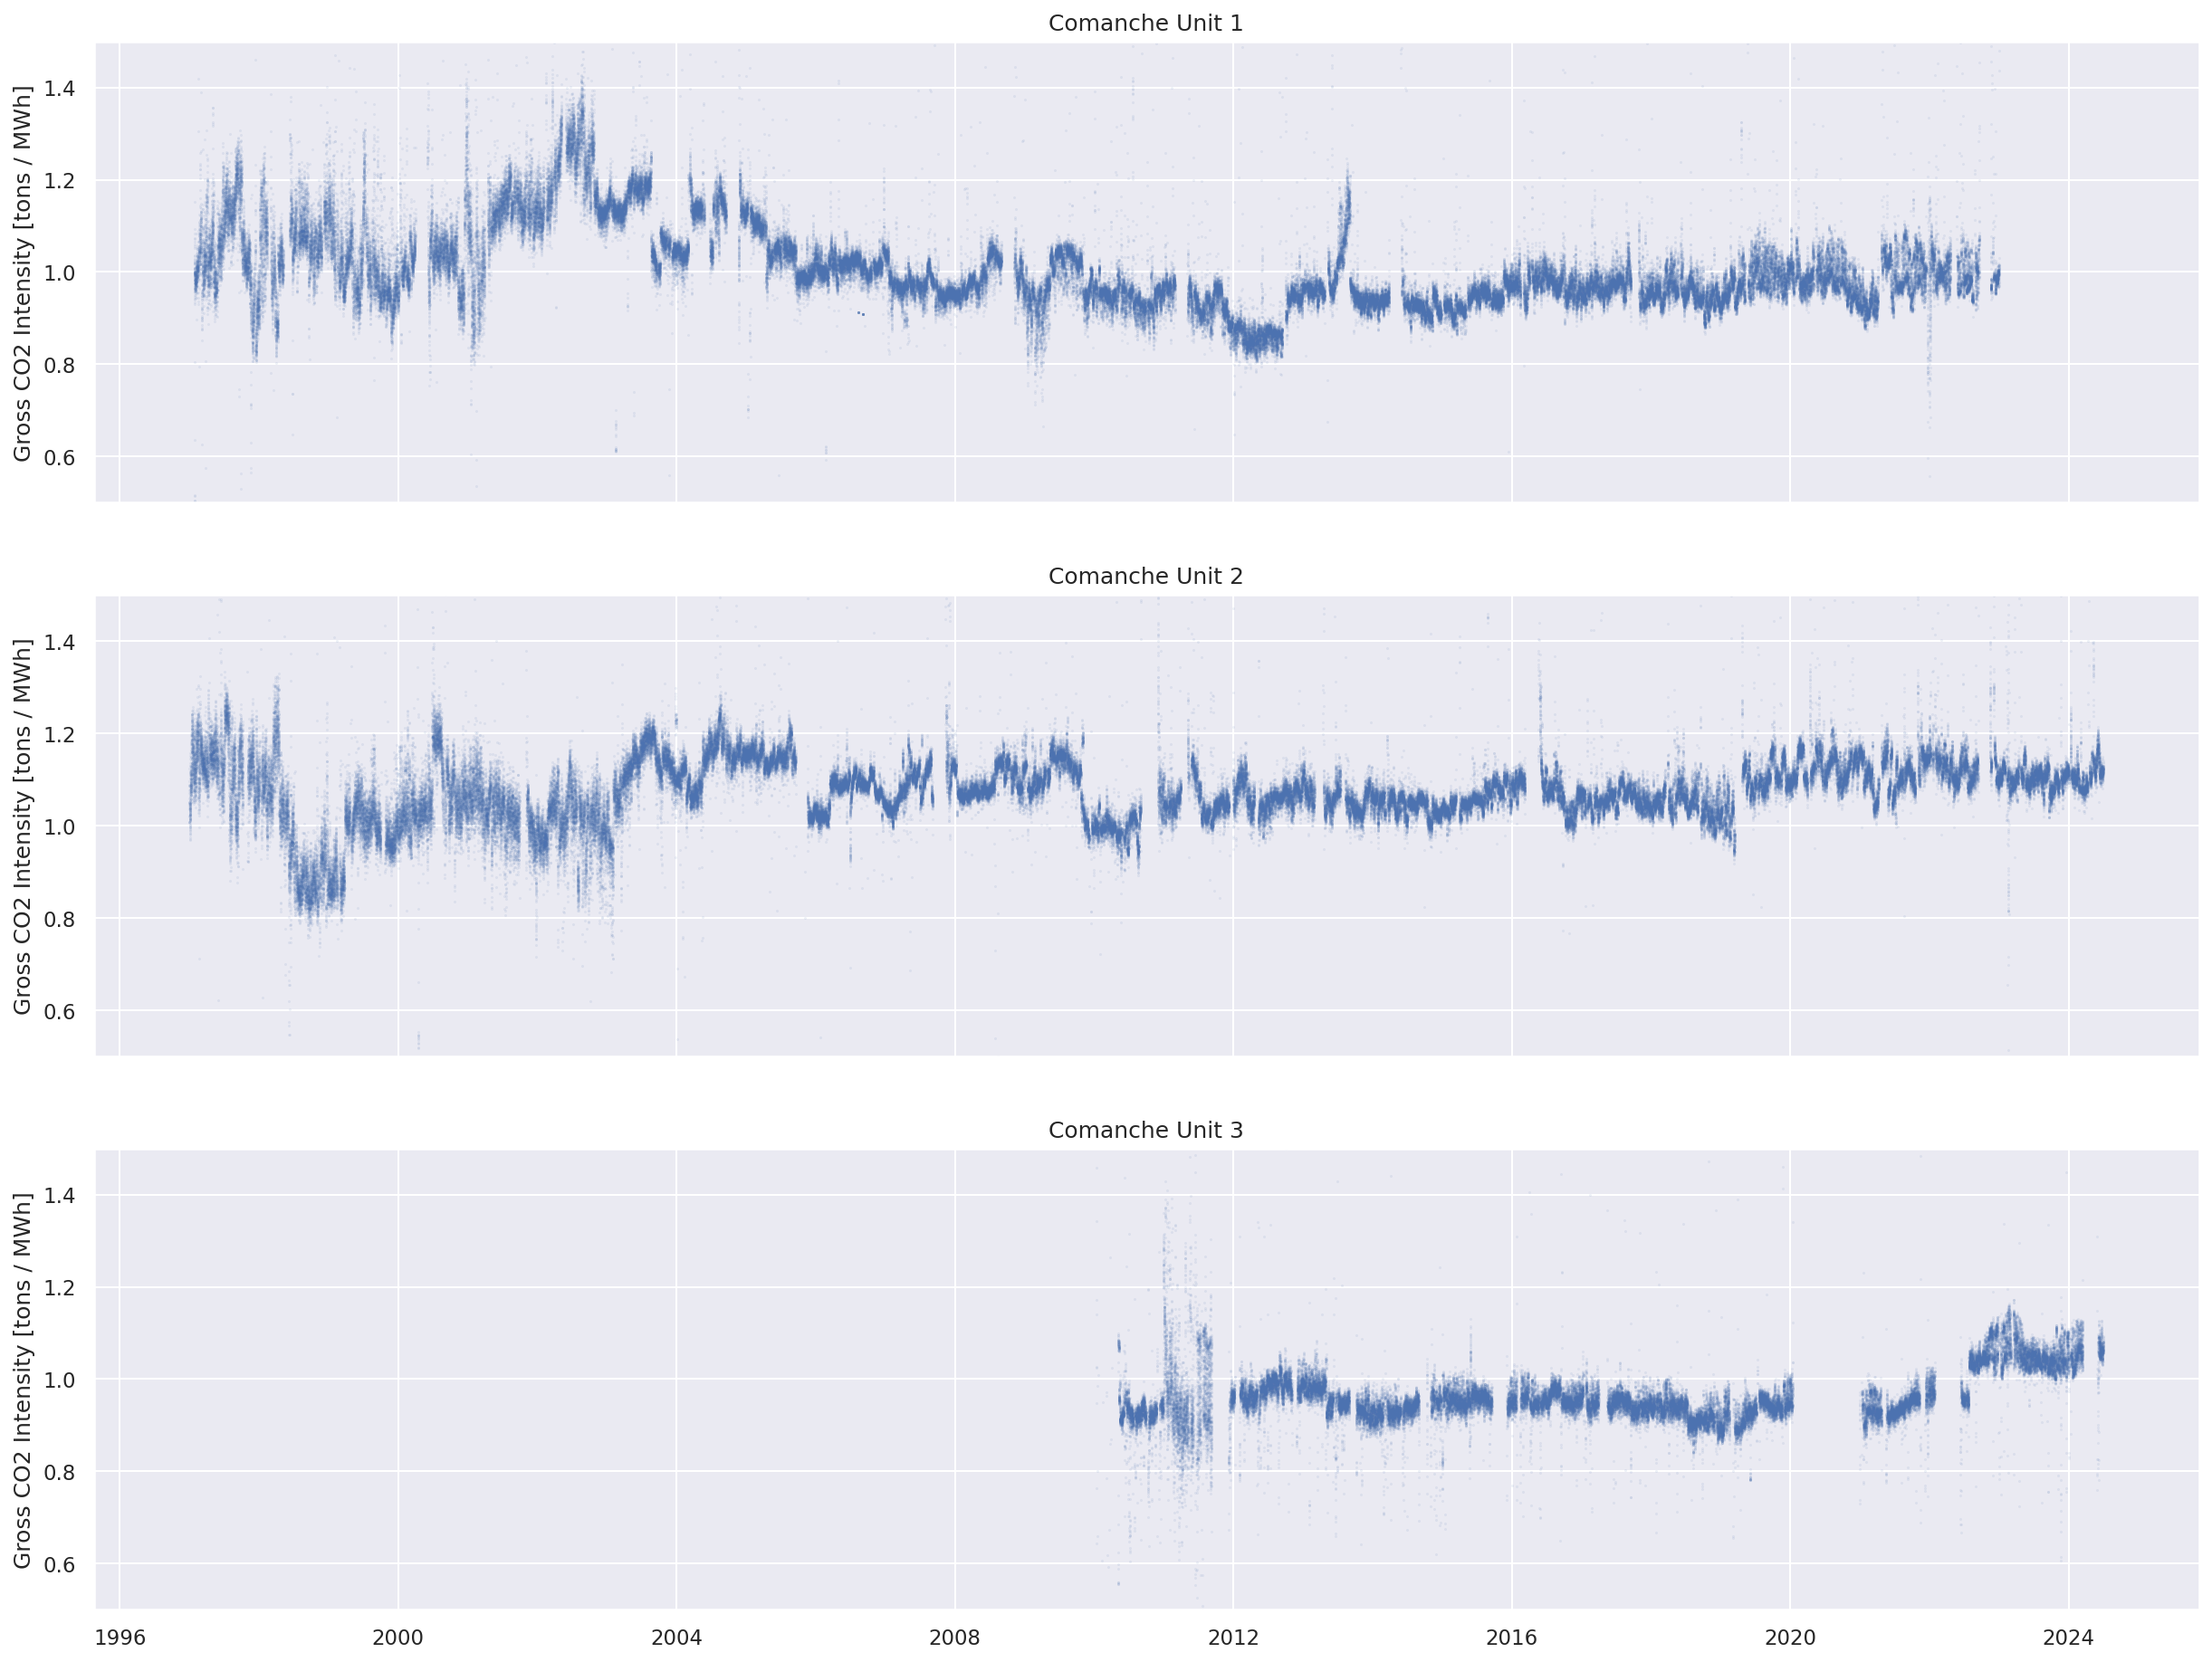

In [18]:
fig, axs = plt.subplots(nrows=len(unit_ids), ncols=1, sharex=True, figsize=(20,15))
for n, unit_id in enumerate(unit_ids):
    axs[n].scatter(
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "operating_datetime_utc"],
        comanche_cems.loc[comanche_cems.emissions_unit_id_epa == unit_id, "gross_co2_intensity"],
        s=0.2, alpha=0.1,
    )
    axs[n].set_ylim(0.5,1.5)
    axs[n].set_title(f"Comanche Unit {unit_id}")
    axs[n].set_ylabel("Gross CO2 Intensity [tons / MWh]")
plt.show();

In [19]:
pd.read_sql("core_pudl__codes_datasources", pudl_engine)

datasource  \
0            epacems   
1              ferc1   
2            ferc714   
3           phmsagas   
4            nrelatb   
5  gridpathratoolkit   
6             eia860   
7            eia860m   
8             eia861   
9             eia923   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                partitions  \
0  [{"year_quarter": "1995q1"}, {"year_quarter": "1995q2"}, {"year_quarter": "1995q3"}, {"year_quarter": "1995q4"}, {"year_quarter": "1996q1"}, {"year_quarter": "1996q2"}, {"year_quarter": "1996q3"}, {"year_quarter": "1996q4"}, {"year_quarter": "1997q1"}, {"year_quarter": "1997q2"}, {"year_quarter": "1997q3"}, {"year_quarter": "1997q4"}, {"year_quarter": "1998q1"}, {"year_quarter": "1998q2"}, {"year_quarter": "1998q3"}, {"year_quarter": "1998q4"}, {"year_quarter": "1999q1"}, {"year_quarter": "1999q2"}, {"year_quarter": "1999q3"}, {"year_quarter": "1999q4"}, {"year_quarter": "2000q1"}, {"year_quarter": "2000q2"}, {"year_quarter": "2000q3"}, {"year_quarter": "2000q4"}, {"year_quarter": "2001q1"}, {"year_quarter": "2001q2"}, {"year_quarter": "2001q3"}, {"year_quarter": "2001q4"}, {"year_quarter": "2002q1"}, {"year_quarter": "2002q2"}, {"year_quarter": "2002q3"}, {"year_quarter": "2002q4"}, {"year_quarter": "2003q1"}, {"year_quarter": "2003q2"}, {"year_quarter": "2003q3"}, {"year_quarter"...   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         [{"year": 1994}, {"year": 1995}, {"year": 1996}, {"year": 1997}, {"year": 1998}, {"year": 1999}, {"year": 2000}, {"year": 2001}, {"year": 2002}, {"year": 2003}, {"year": 2004}, {"year": 2005}, {"year": 2006}, {"year": 2007}, {"year": 2008}, {"year": 2009}, {"year": 2010}, {"year": 2011}, {"year": 2012}, {"year": 2013}, {"year": 2014}, {"year": 2015}, {"year": 2016}, {"year": 2017}, {"year": 2018}, {"year": 2019}, {"year": 2020}, {"year": 2021}, {"year": 2022}, {"year": 2023}]   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      